# Module 5: Cointegration, Long-Horizon Regressions, and <br>Pairs-Trading

For this module session, we'll be comparing numerical implementations of co-integration and vector error-correction models (**VECM**) as well as long-horizon regressions. 

We start with a few examples. Then, we will look at an application of cointegration from **Lettau and Ludvigson (Journal of Finance; 2001, 2004)**, which introduces the asset valuation measure $\widehat{cay}$, constructed as a measure of short-term deviations from a long-run cointegration relationship among the natural logarithms of: 
1. consumption ($c$),
2. human capital wealth i.e. labor income ($y$) 
3. non-human capital wealth; wealth i.e. aggregate wealth ($a$).

This relationship is obtained from a present-discounted value relationship implied from an aggregate economy's budget constraint. The mathematical derivation is similar in spirit to that of **Campbell and Shiller (1988, 1991)**.

In brief, $\widehat{cay}$ is a proxy for the **consumption-wealth ratio** and is able to explain a large fraction of the cross-sectional variation of asset prices in the sample studied by the aforementioned authors. 

Lastly, we look at a trading strategy resulting from an application of co-integration: **pairs trading**. Pairs trading is a market-neutral trading strategy that employs long-short positions in a pair of highly co-moving assets. Co-movement will be given by a co-integrating relationship. 

As usual, we start by importing all of the necessary Python packages/libraries. 

In [1]:
### Imports
from __future__ import print_function, division

import sys
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order

from datetime import date, datetime, timedelta
import copy

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

from importlib import reload
import itertools

from IPython.display import display, HTML
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    CSS = """.output {vertical-align: middle;}"""

    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
        '<style>{}</style>'.format(CSS)
    )
from ipy_table import*

import datetime as dt
from datetime import date, timedelta
from calendar import month_abbr
from pandas.tseries.offsets import Day, MonthEnd

### Plotting and display options
np.set_printoptions(precision=5)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin. See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin. See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

### Figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

### This allows plots to appear directly in the notebook
%matplotlib inline

# Example 1: 

Let $\mathbf{X}_t=(x_{1,t},x_{2,t})^{\prime}$ and $x_{1,t},x_{2,t}\sim I(1)$.  

$x_{1,t}$ and $x_{2,t}$ are **cointegrated** with **cointegration vector** $\mathbf{\alpha}=(\alpha_1, \alpha_2)^{\prime}$, so that $z_t = \mathbf{\alpha}' \mathbf{X}_t \sim I(0)$.

Consider the following VECM(1):

$$
\begin{align*}
    \Delta x_{1,t} & = {{\gamma_1\, z_{t-1}}} + \phi_{11} \Delta x_{1,t-1}  + \phi_{12} \Delta x_{2,t-1} + \epsilon_{1,t} \\   
    \Delta x_{2,t} & = {{\gamma_2\, z_{t-1}}} + \phi_{21} \Delta x_{1,t-1} +  \phi_{22} \Delta x_{2,t-1} + \epsilon_{2,t}\\[3mm]
    \Leftrightarrow \Delta \mathbf{X}_t & = \mathbf{\gamma} \mathbf{\alpha}' \mathbf{X}_{t-1} + 
    \mathbf{\Phi}_1 \Delta \mathbf{X}_{t-1} + \mathbf{\epsilon}_t\\[3mm]
    \mathbf{\gamma} &= 
    \begin{pmatrix}
        \gamma_1 \\ \gamma_2
    \end{pmatrix},
    \mathbf{\Phi}_1 = 
    \begin{pmatrix}
        \phi_{11} & \phi_{12} \\ \phi_{21} & \phi_{22}
    \end{pmatrix}
\end{align*}
$$


Let's define the matrix $\mathbf{\Pi}= \mathbf{\gamma} \mathbf{\alpha}'$:
$$
\begin{align*}
    \mathbf{\Pi}\equiv
    \begin{pmatrix}
        \pi_{11}  & \pi_{12} \\ \pi_{21} & \pi_{22}
    \end{pmatrix} 
    =  
    \begin{pmatrix}
        \gamma_1 \\ \gamma_2
    \end{pmatrix} \cdot
     \begin{pmatrix}
        \alpha_1, \alpha_2
    \end{pmatrix} = 
    \begin{pmatrix}
        \gamma_1 \alpha_1 & \gamma_1 \alpha_2  \\ \gamma_2 \alpha_1 &  \gamma_2 \alpha_2
    \end{pmatrix} 
\end{align*}    
$$

## Part A: 

Write the VECM($1$) as a VAR($p$): 
$$
\begin{align*}
    \mathbf{\Psi}(L) \mathbf{X}_t = \mathbf{\epsilon}_t
\end{align*}    
$$

Solve for $\mathbf{\Psi}(L)$ in terms of the VECM coefficients $\mathbf{\gamma}$ and $\mathbf{\Phi}_1$.
What is the lag order $p$ of the VAR?

**Note:** The vector $\epsilon$ can be assume to be a vector White noise process such that:

$$
\begin{align*}
   \mathbf{\epsilon}_t \sim i.i.d.  WN(\mathbf{0}, \mathbf{\Sigma_\epsilon}) \\ \\
   \mathbf{\Sigma_\epsilon} = 
   \begin{pmatrix}
        1  &  0 \\ 0 & 1
   \end{pmatrix} 
\end{align*}   
$$

## Solution to Part A:

From **Lecture 5**, a VECM($p$) has a VAR($p+1$) representation. We can rewrite the  VECM($1$) as follows:

$$
\begin{align*}
    \mathbf{X}_t - \mathbf{X}_{t-1} & = \mathbf{\gamma} \mathbf{\alpha}' \mathbf{X}_{t-1} + 
    \mathbf{\Phi}_1 \mathbf{X}_{t-1} - \mathbf{\Phi}_1 \mathbf{X}_{t-2} + \mathbf{\epsilon}_t \\[2mm]
    \Leftrightarrow\;  \mathbf{X}_t & = (\mathbf{\gamma} \mathbf{\alpha}' + {\bf I_2} + \mathbf{\Phi}_1)\mathbf{X}_{t-1} - \mathbf{\Phi}_1 \mathbf{X}_{t-2} + \mathbf{\epsilon}_t
\end{align*}
$$

Rearranging terms will then give us the expression for the lag matrix polynomial $\mathbf{\Psi}(L)$:

$$
\begin{align*}
    \mathbf{X}_t & = (\mathbf{\gamma} \mathbf{\alpha}' + {\bf I}_2 + \mathbf{\Phi}_1)\mathbf{X}_{t-1} -               \mathbf{\Phi}_1 \mathbf{X}_{t-2} + \mathbf{\epsilon}_t \\[2mm]
    \Leftrightarrow\;  ({\bf I}_2 - (\mathbf{\gamma} \mathbf{\alpha}' + {\bf I}_2 + \mathbf{\Phi}_1)L + \mathbf{\Phi}_1 L^2)\mathbf{X}_t & = \mathbf{\epsilon}_t  \\[2mm]
        \Leftrightarrow\;   \mathbf{\Psi}(L)\mathbf{X}_t & = \mathbf{\epsilon}_t
\end{align*}
$$

Let's define the following matrices: 

$$
\begin{align*}
    \mathbf{\Lambda}_0 = {\bf I}_2, \;
    \mathbf{\Lambda}_1 = (\mathbf{\gamma} \mathbf{\alpha}' + {\bf I}_2 + \mathbf{\Phi}_1), \;
    \mathbf{\Lambda}_2 = -\mathbf{\Phi}_1
\end{align*}
$$

Hence, we end up with $\mathbf{\Psi}(L)\equiv (\mathbf{\Lambda}_0 -  \mathbf{\Lambda}_1 L - \mathbf{\Lambda}_2 L^2)$ where

$$
\begin{align*}
    \mathbf{\Lambda}_1 & = 
    \begin{pmatrix}
        (\gamma_1 \alpha_1 + 1) +  \phi_{11} & \gamma_1 \alpha_2       +  \phi_{21} \\ 
        \gamma_2 \alpha_1       + \phi_{12}  & (\gamma_2 \alpha_2 + 1) +  \phi_{22}
    \end{pmatrix} 
\end{align*}
$$

or, as we usually see a VAR($2$), we have: 

$$
\begin{align*}
    \mathbf{X}_t = \mathbf{\Lambda}_1 \mathbf{X}_{t-1} + \mathbf{\Lambda}_2 \mathbf{X}_{t-2} +                       \mathbf{\epsilon}_t = 
    \begin{pmatrix}
            \mathbf{\Lambda}_1 & \mathbf{\Lambda}_2 
    \end{pmatrix} \cdot
    \begin{pmatrix}
            \mathbf{X}_{t-1}\\ \mathbf{X}_{t-2}
    \end{pmatrix} 
    + \mathbf{\epsilon}_t
\end{align*}
$$


### Digression: 
We can also write down the VAR($2$) system into a VAR($1$) by a stacking the matrices as follows:

$$
\begin{align*}
    \mathbf{\Lambda} & = 
    \begin{pmatrix}
        \mathbf{\Lambda}_1 & \mathbf{\Lambda}_2 \\ {\bf I}_2  & {\bf 0}_{2\times 2}  
     \end{pmatrix}\\[2mm]
     \text{w/ } {\bf 0}_{2\times 2} & = 
     \begin{pmatrix}
        0 & 0 \\ 0 & 0  
     \end{pmatrix}\\[2mm]
     \widetilde{\mathbf{X}}_t & = 
     \begin{pmatrix}
       \mathbf{X}_t \\ \mathbf{X}_{t-1}
     \end{pmatrix},\;
     \widetilde{\mathbf{X}}_{t-1} = 
     \begin{pmatrix}
       \mathbf{X}_{t-1} \\  \mathbf{X}_{t-2}
     \end{pmatrix},\;
     \widetilde{\mathbf{\epsilon}}_{t} = 
     \begin{pmatrix}
      \mathbf{\epsilon}_{t}\\ 0 \\ 0 
     \end{pmatrix},    
\end{align*}
$$

The dimensions of the aforementioned matrices are as follows: 
* $\mathbf{\Lambda}$ is $(4 \times 4)$
* $\widetilde{\mathbf{X}}_{t}$, $\widetilde{\mathbf{X}}_{t-1}$, and $\widetilde{\mathbf{\epsilon}}_{t}$ are each $(4 \times 1)$

Our stacked VAR($1$) representation is then given by:
$$
\begin{align*}
    \widetilde{\mathbf{X}}_{t} = \mathbf{\Lambda} \widetilde{\mathbf{X}}_{t-1} + \widetilde{\mathbf{\epsilon}}_{t}
\end{align*}
$$
This stacked representation is extremely useful for some estimation procedures.

## PART B: 

Now consider the special case $\mathbf{\alpha}=(1,-1)^{\prime}$.  

What restrictions of the VAR coefficients are implied by the VECM($1$)?  

## Solution to Part B:

If $\mathbf{\alpha}=(1,-1)^{\prime}$, then 


$$
\begin{align*}
    \mathbf{\Lambda}_1 = 
    \begin{pmatrix}
        \gamma_1 + 1 +  \phi_{11} &  -\gamma_1     +  \phi_{21} \\ 
        \gamma_2    + \phi_{12}   &  -\gamma_2 + 1 +  \phi_{22}
    \end{pmatrix}, \;
    \mathbf{\Lambda}_2 = 
    \begin{pmatrix}
        -\phi_{11} &  -\phi_{21} \\ 
        -\phi_{12} &  -\phi_{22}
    \end{pmatrix} 
\end{align*}
$$

It is then clear that the implied restrictions are:

$$
\begin{align*}
    \mathbf{\Lambda}_1[1,:] +  \mathbf{\Lambda}_2[1,:] = 1 \\ 
    \mathbf{\Lambda}_1[2,:] +  \mathbf{\Lambda}_2[2,:] = 1 \\ 
\end{align*}
$$

i.e. the combined rows sum to 1!

## PART C:

Next, let's run some simulations. Fix the following:

$$
\begin{align*}
    \mathbf{\alpha} = 
    \begin{pmatrix}
            1 \\ -1
    \end{pmatrix},\; \; 
    \mathbf{\Phi}_1 = 
    \begin{pmatrix}
        0.2 & -0.1 \\ 0 & -0.25
    \end{pmatrix}
\end{align*}     
$$

for all simulations.  Consider four cases for $\mathbf{\gamma}$:

$$
\begin{align*}
    \mathbf{\gamma}_1 &= (0, 0.3)^{\prime} \\
    \mathbf{\gamma}_2 &= (0, 0.03)^{\prime} \\
    \mathbf{\gamma}_3 &= (-0.25, 0.1)^{\prime} \\
    \mathbf{\gamma}_4 &= (-0, 0)^{\prime}
\end{align*} 
$$ 
      
and $T_1=250$ and $T_2=2500$. 
For simplicity, let's analyze a single simulation for each combination of $\mathbf{\gamma}_i$ and $T_j$. 
For each combination of $\mathbf{\gamma}_i$ and $T_j$, estimate each of the following:

1. VECM($1$)
2. VAR in $\mathbf{X}_t$ with the <u>optimal lag length</u> according to the *BIC*
3. VAR in $\Delta\mathbf{X}_t$ with the <u>optimal lag length</u> according to the *BIC*.

**Q1: Which estimation specification(s) are most appropriate for the different cases?** <br> 
**Q2: What are the tradeoffs of the different specifications?**
      

## Solution to Part C:

Let's first specify the four different $\mathbf{\gamma}_i$'s, $i=1,2,3,4$:

In [2]:
gamma_vecm_all = [np.array(np.mat('0; 0.3')), 
                  np.array(np.mat('0; 0.03')),
                  np.array(np.mat('-0.25; 0.1')),
                  np.array(np.mat('-0; 0'))]


gamma_vecm1 = [np.array(np.mat('0; 0.3'))]

Phi1_vecm = np.array(np.mat('.2 -.1; \
                              .0 -.25'))

### KNOWN Cointegrating vector
alpha_vecm = np.array(np.mat('1; -1'))

nsample_T = [250, 2500]

### Display "alpha" and "Phi1"
print('(cointegrating vector) alpha =', alpha_vecm.flat[:], '\n')
print('Phi1  =\n', Phi1_vecm, '\n')

(cointegrating vector) alpha = [ 1 -1] 

Phi1  =
 [[ 0.2  -0.1 ]
 [ 0.   -0.25]] 



### Case $j=1$: $\mathbf{\gamma}_1 = (0, 0.3)'$

Throughout **Example 1**, we will focus on this special case for $\gamma$. Our code will be general enough to look at the other three cases, separately or jointly.

Thus, we can assign the `NumPy` matrix list `gamma_vecm1` to the variable `gamma_vecm0` (if we wanted to analyze all four cases, we would set`gamma_vecm0=gamma_vecm_all`.

In [3]:
j = 0 # NumPy index for this case within "gamma_vecm_all" 
gamma_vecm = gamma_vecm1
print('gamma_'+ str(j+1) + ':\n', gamma_vecm[0].flat[:])

gamma_1:
 [0.  0.3]


Let's write down and print the matrix lag polynomial $\mathbf{\Psi}(L)$ for $\mathbf{\gamma}_1 = (0, 0.3)^{\prime}$

In [4]:
for j in range(0, len(gamma_vecm)):
    print('j =', str(j+1), ': gamma =', gamma_vecm[j].flat[:], '\n')    
    PI_vecm = np.dot(gamma_vecm[j], alpha_vecm.T)
    print('\tPI =\n', PI_vecm, '\n')
    
    ### VAR(2) representation
    Lambda0_var = np.eye(2)
    Lambda1_var = PI_vecm + np.eye(2) + Phi1_vecm
    Lambda2_var = -Phi1_vecm

    print('\tPsi(L) = (Lambda0 - Lambda1*L - Lambda2*(L^2) w/:')
    print('\tLambda0 =\n', Lambda0_var)
    print('\tLambda1 =\n', Lambda1_var)
    print('\tLambda2 =\n', Lambda2_var, '\n\n')

j = 1 : gamma = [0.  0.3] 

	PI =
 [[ 0.  -0. ]
 [ 0.3 -0.3]] 

	Psi(L) = (Lambda0 - Lambda1*L - Lambda2*(L^2) w/:
	Lambda0 =
 [[1. 0.]
 [0. 1.]]
	Lambda1 =
 [[ 1.2  -0.1 ]
 [ 0.3   0.45]]
	Lambda2 =
 [[-0.2   0.1 ]
 [-0.    0.25]] 




In [5]:
df_var2_j = pd.DataFrame(index=['Pi', 'Lambda0_var', 'LAMBDA_var', 'Cov_eps', 'var2_stable'], 
                         columns=['gamma1', 'gamma2', 'gamma3', 'gamma4'])

for j in range(0, len(gamma_vecm)):    
    ### gamma_{j}:
    print('j =', str(j+1), ': gamma =', gamma_vecm[j].flat[:], '\n')  
    Pi_vecm = np.dot(gamma_vecm[j], alpha_vecm.T)

    ### VAR(2) representation:
    Lambda0_var = np.eye(2)
    Lambda1_var = Pi_vecm + np.eye(2) + Phi1_vecm
    Lambda2_var = -Phi1_vecm

    LAMBDA_var = np.ndarray(shape=(2, 2, 2))
    LAMBDA_var[0] = Lambda1_var
    LAMBDA_var[1] = Lambda2_var       
    print("\tLambda matrices (Lambda1 & Lambda2) = \n", LAMBDA_var, '\n')

    ### Check restrictions on rows of coefficient matrix in VAR(2) adding up to one
    print('\tsum elements of LAMBDA in 1st rows: ', np.sum(LAMBDA_var[:,0,:]))
    print('\tsum elements of LAMBDA in 2nd rows: ', np.sum(LAMBDA_var[:,1,:]), '\n')

    ### Variance-covariance matrix of epsilon
    Cov_eps = np.array(np.mat('1 0; 0 1'))

    ### Check if VAR(2) representation is "stable":
    var2_model = VARProcess(coefs=LAMBDA_var, coefs_exog=None, sigma_u=Cov_eps)   
    var2_stable = var2_model.is_stable(verbose=True)
    print('\n\tIs the VAR(2) stable?:', var2_stable, '\n\n')

    ### Store objects in 'DataFrame' "df_var2"
    col_j = 'gamma' + str(j+1)
    df_var2_j.loc['Pi', col_j] = Pi_vecm
    df_var2_j.loc['LAMBDA_var', col_j] = LAMBDA_var
    df_var2_j.loc['Cov_eps', col_j] = Cov_eps
    df_var2_j.loc['var2_stable', col_j] = var2_stable
    

j = 1 : gamma = [0.  0.3] 

	Lambda matrices (Lambda1 & Lambda2) = 
 [[[ 1.2  -0.1 ]
  [ 0.3   0.45]]

 [[-0.2   0.1 ]
  [-0.    0.25]]] 

	sum elements of LAMBDA in 1st rows:  0.9999999999999999
	sum elements of LAMBDA in 2nd rows:  1.0 

Eigenvalues of VAR(1) rep
0.9999999999999986
0.7343088851315472
0.22217155611843176
0.3064804412499776

	Is the VAR(2) stable?: True 




To simulate our VECM($1$) for $\mathbf{\gamma}_1 = (0, 0.3)^{\prime}$ and $T=250,2500$, we can make use of **Part A** and instead simulate the VAR($2$) representation of the model:

In [6]:
df_var2 = pd.DataFrame(index=['T='+ str(T) for T in nsample_T], 
                       columns=['gamma1', 'gamma2', 'gamma3', 'gamma4'])

### For gamma_{j}, j=1,2,3,4;
### For T = {250, 2,500}
for j in range(0, len(gamma_vecm)):
    for T in nsample_T:
        row_T = 'T=' + str(T)
        col_j = 'gamma' + str(j+1)

        var2_model = VARProcess(coefs=df_var2_j.loc['LAMBDA_var', col_j], 
                                coefs_exog=None, sigma_u=df_var2_j.loc['Cov_eps', col_j])   

        X = var2_model.simulate_var(T)
        Z = np.dot(X, alpha_vecm).squeeze()
        dX = np.diff(X, axis=0)
        sim_T_j = {'time': np.arange(0, len(X[1:,0])), 
                   'x1': X[1:,0], 'x2': X[1:,1], 'z':Z[1:], 'dx1': dX[:,0], 'dx2': dX[:,1]}
        df_var2.loc[row_T, col_j] = [sim_T_j]
   

We now plot each of our simulations for $T\in \{250, 2500\}$ and $\mathbf{\gamma}_1 = (0, 0.3)^{\prime}$.

In [7]:
def plot_var2_simulation(df_var2, row_T):
    
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))        
        axes[0].plot(df_var2.loc[row_T_label, col_j][0]['time'][-200:], 
                     df_var2.loc[row_T_label, col_j][0]['x1'][-200:], label='x1')
        axes[0].plot(df_var2.loc[row_T_label, col_j][0]['time'][-200:], 
                     df_var2.loc[row_T_label, col_j][0]['x2'][-200:], label='x2', alpha=.95)
        axes[0].set_title('$\mathbf{X}_t$\n($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', 
                          fontsize=24)
        axes[0].set_xlabel('Time', fontsize=22)
        axes[0].legend(fontsize=24)

        axes[1].plot(df_var2.loc[row_T_label, col_j][0]['time'][-200:], 
                     df_var2.loc[row_T_label, col_j][0]['z'][-200:], label='z')
        axes[1].set_title('Cointegration error $z_t=\mathbf{\\alpha}_j^{\prime}\mathbf{X}_t$\n($T$=' + str(row_T) + ', $\gamma$'+ str(j+1) + ')', 
                          fontsize=24)
        axes[1].set_xlabel('Time', fontsize=22)
        axes[1].legend(fontsize=24)     

    fig.tight_layout()

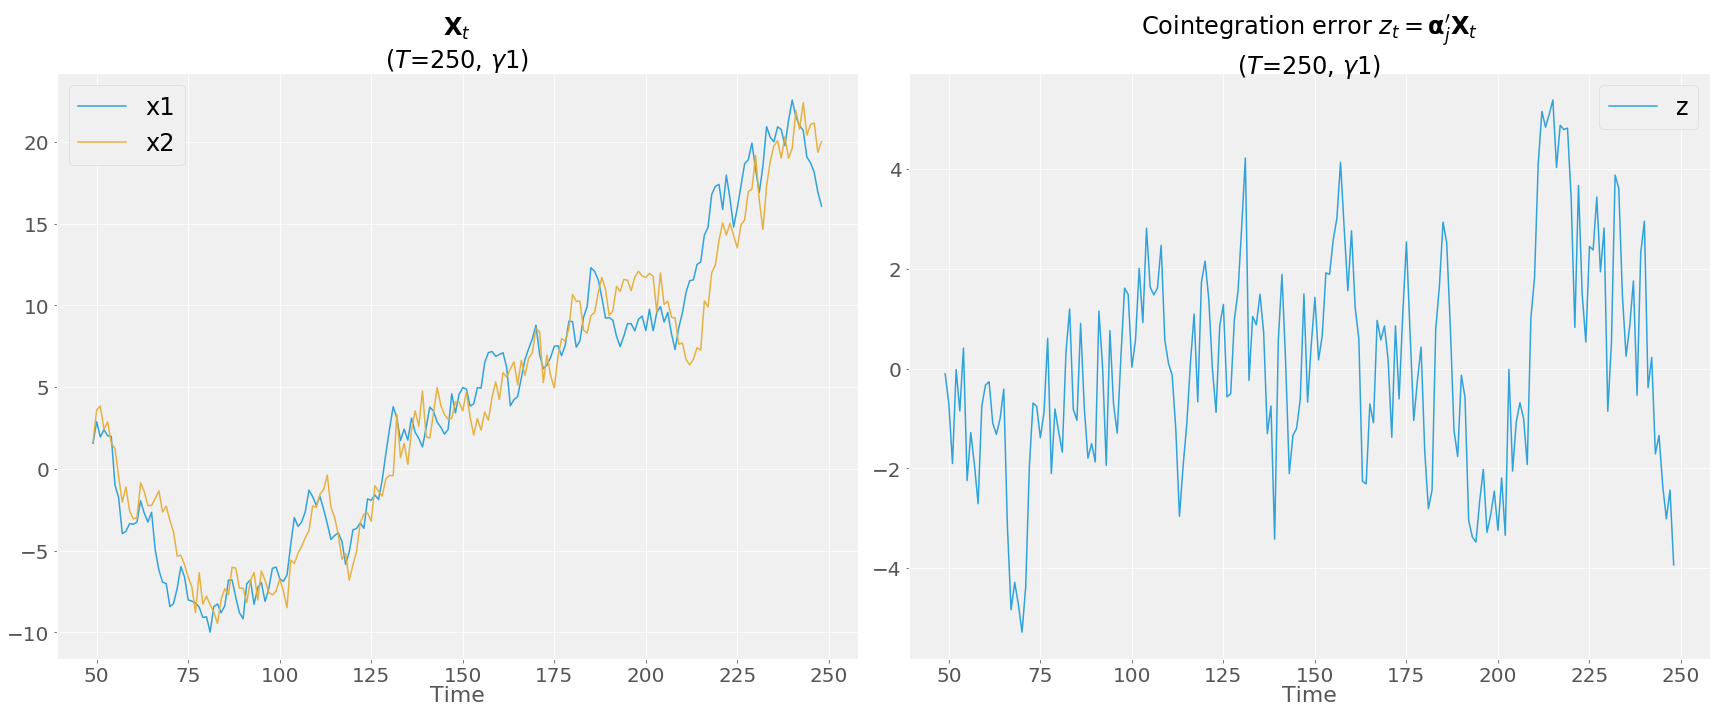

In [8]:
### Plot VAR(2) simulations for T = 250
plot_var2_simulation(df_var2=df_var2, row_T=250)   

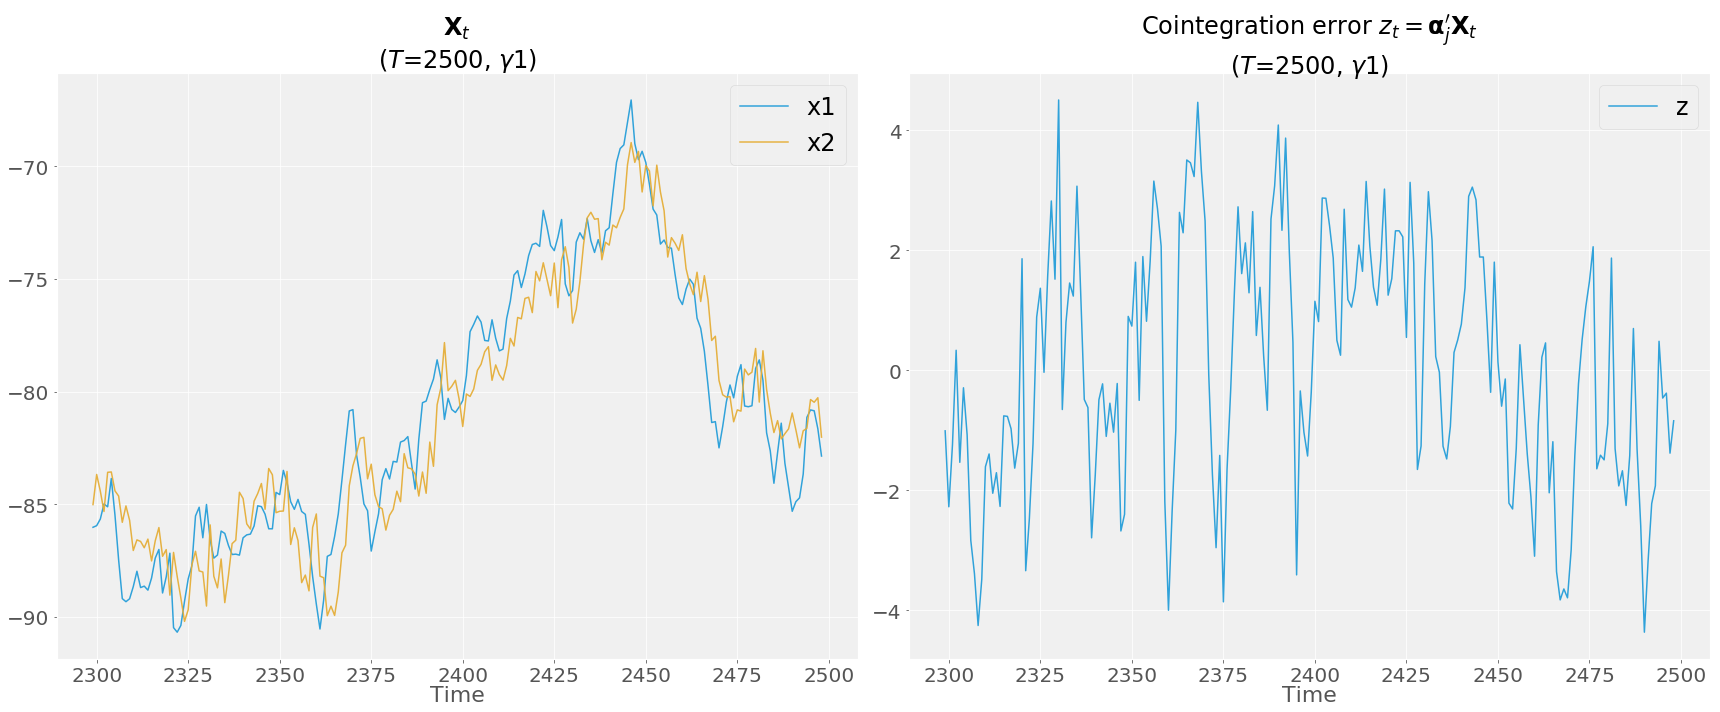

In [9]:
### Plot VAR(2) simulations for T = 2500
plot_var2_simulation(df_var2=df_var2, row_T=2500)  

Let's look at the *ACF* and *PACF* for each simulation:

In [10]:
def plot_acf_var2_simulation(df_var2, row_T, nlags=20):
    
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))  
        sm.tsa.graphics.plot_acf(df_var2.loc[row_T_label, col_j][0]['x1'], ax=axes[0], lags=nlags)
        sm.tsa.graphics.plot_acf(df_var2.loc[row_T_label, col_j][0]['x2'], ax=axes[1], lags=nlags) 
        axes[0].set_title('${\it ACF}$ of $x_1$\n ($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', fontsize=22)
        axes[1].set_title('${\it ACF}$ of $x_2$\n ($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')' , fontsize=22)
        axes[0].set_xlabel('Lags', fontsize=22)
        axes[1].set_xlabel('Lags', fontsize=22)

    fig.tight_layout()

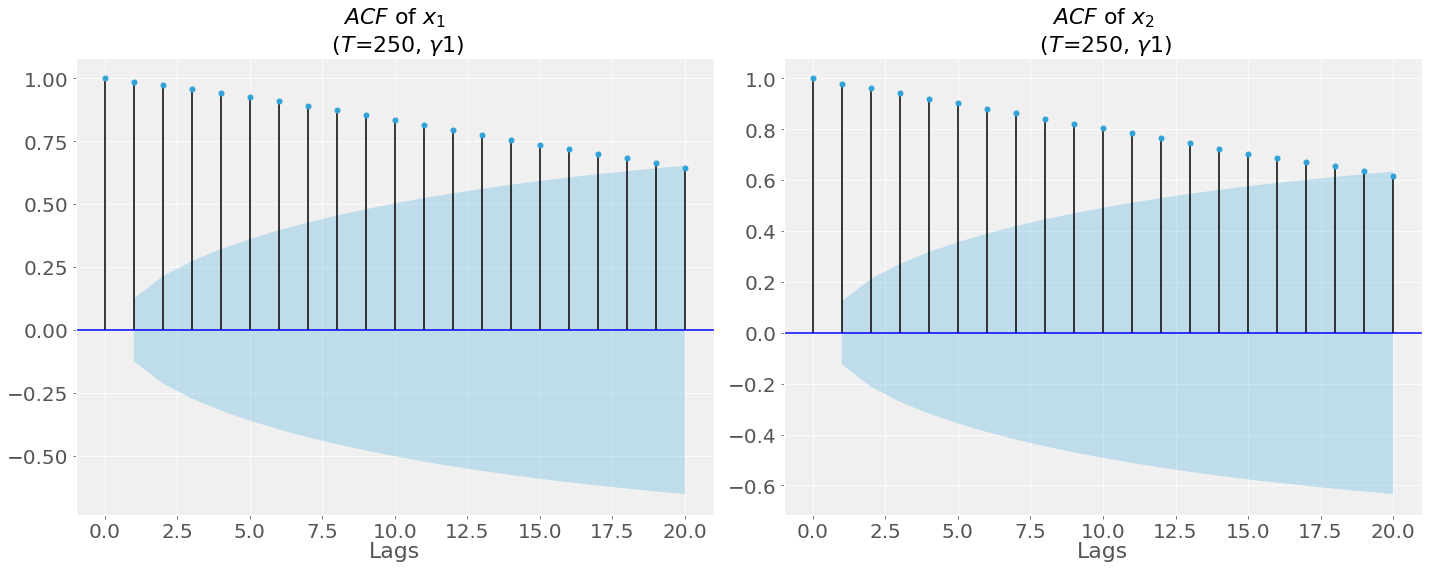

In [11]:
### Plot VAR(2) ACF for T = 250
plot_acf_var2_simulation(df_var2=df_var2, row_T=250, nlags=20)  

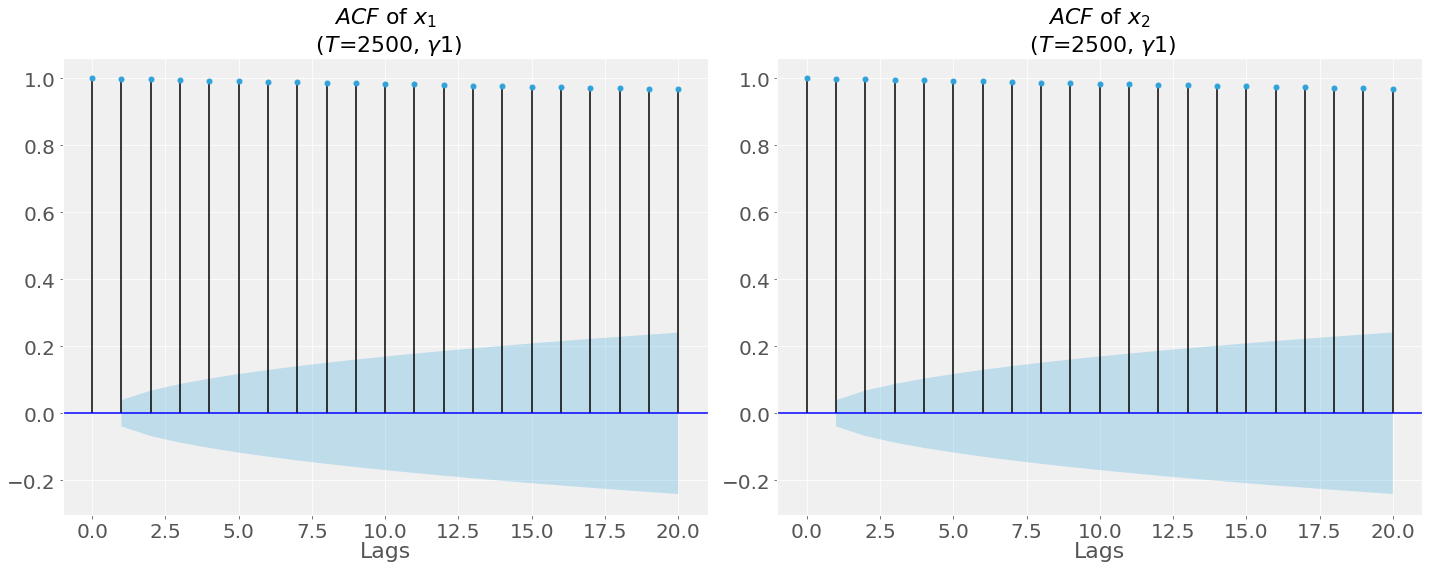

In [12]:
### Plot VAR(2) ACF for T = 2500
plot_acf_var2_simulation(df_var2=df_var2, row_T=2500, nlags=20)  

Let's also run unit root tests (i.e. **Augmented-Dickey Fuller** test) to asses whether our processes have a unit root. 

In [13]:
def ADF_test(df_var2, row_T): 
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')')
        
        adf_result1 = sm.tsa.stattools.adfuller(df_var2.loc[row_T_label, col_j][0]['x1'])
        print('\tx1: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result1[0], adf_result1[1]),
              '\n\tcritical values', adf_result1[4],'\n')
     
        adf_result2 = sm.tsa.stattools.adfuller(df_var2.loc[row_T_label, col_j][0]['x2'])
        print('\tx2: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result2[0], adf_result2[1]),
              '\n\tcritical values', adf_result2[4], '\n')

        adf_result3 = sm.tsa.stattools.adfuller(df_var2.loc[row_T_label, col_j][0]['z'])
        print('\tz:  ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result3[0], adf_result3[1]),
              '\n\tcritical values', adf_result3[4], '\n\n')

In [14]:
### Augmented Dickey-Fuller test for T=250
ADF_test(df_var2, row_T=250)

j = 1 : (T =250 , gamma = [0.  0.3] )
	x1: ADF statistic (p-value): -0.490 (0.894) 
	critical values {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674} 

	x2: ADF statistic (p-value): 0.070 (0.964) 
	critical values {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606} 

	z:  ADF statistic (p-value): -4.551 (0.000) 
	critical values {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606} 




In [15]:
### Augmented Dickey-Fuller test for T=2500
ADF_test(df_var2, row_T=2500)

j = 1 : (T =2500 , gamma = [0.  0.3] )
	x1: ADF statistic (p-value): -1.303 (0.628) 
	critical values {'1%': -3.432972611342269, '5%': -2.862698654944332, '10%': -2.567386797035513} 

	x2: ADF statistic (p-value): -1.228 (0.662) 
	critical values {'1%': -3.4329736635735393, '5%': -2.8626991196096556, '10%': -2.5673870444295406} 

	z:  ADF statistic (p-value): -16.760 (0.000) 
	critical values {'1%': -3.432972611342269, '5%': -2.862698654944332, '10%': -2.567386797035513} 




Based on the **Augmented Dickey-Fuller** test, for $T=250$ and $T=2500$, we fail to reject the null hypothesis $\mathbf{H}_0$ that $x_1$ and $x_2$ have unit roots in favor of the alternative (at the 1%, 5%, and 10% significance levels). 

However, we can reject the null hypothesis of a unit root for $z$!

### Addendum:

Following the unit root tests, we can test for no co-integration of our univariate equation $z_t=\mathbf{\alpha}_t^{\prime}\mathbf{X}_t$ using the **augmented Engle-Granger two-step cointegration test**, which sets the null hypothesis $\mathbf{H }_0$ to that of no co-integration. 

Using `statsmodels` we can implement this test with the [`statttols.coint`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html) function

In [16]:
def AEG_coint_test(df_var2, row_T): 
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')')
        
        x1 = df_var2.loc[row_T_label, col_j][0]['x1']
        x2 = df_var2.loc[row_T_label, col_j][0]['x2']
        
        aeg_result = sm.tsa.stattools.coint(x1, x2, trend='c')
        
        print('\tAEG statistic (p-value): %0.3f (%0.3f)' % (aeg_result[0], aeg_result[1]),
              '\n\t(1%, 5%, 10%) critical values', aeg_result[2],'\n')
        

In [17]:
### Augmented Engle-Granger two-step cointegration test for T=250
AEG_coint_test(df_var2, row_T=250)

j = 1 : (T =250 , gamma = [0.  0.3] )
	AEG statistic (p-value): -4.588 (0.001) 
	(1%, 5%, 10%) critical values [-3.94115 -3.36088 -3.0616 ] 



In [18]:
### Augmented Engle-Granger two-step cointegration test for T=2500
AEG_coint_test(df_var2, row_T=2500)

j = 1 : (T =2500 , gamma = [0.  0.3] )
	AEG statistic (p-value): -16.764 (0.000) 
	(1%, 5%, 10%) critical values [-3.90083 -3.33858 -3.04615] 



For $T=250$ and $T=2500$, we reject the null hypothesis $\mathbf{H}_0$ of no cointegrating relationship between $x_1$ and $x_2$ in favor of the alternative (at the 1%, 5%, and 10% significance levels).

### 1. VECM 
Let's estimate a VECM($1$) for each of our simulations. First, we need to get the cointegrating errors $z_t = \mathbf{\alpha}^{\prime} \mathbf{X}_{t-1}$. Here, we know what the cointegrating vector is, else we would first have to first estimate it to get $z_t$
* **Note:** We can use **OLS**, **Dynamic OLS**, or the **Johansen procedure** - more on the this later.

We can also write a separate function that provides us with the time-series of the cointegrating vector $z_t$. Note, **we already saw this in the plots produced by `plot_var2_simulation`** and $z_t$ is already stored in the DataFrame `df_var2`. 

### Estimating the cointegrating vector $\mathbf{\alpha}$ for $\mathbf{\gamma}_1 = (0, 0.3)^{\prime}$

Suppose we didn't know the cointegrating vector $\mathbf{\alpha}$ then, we could estimate it via:
1. **OLS**
2. **Dynamic OLS**
3. **Johansen Procedure**

We will skip the last method, due to its complexity, and for the sake of time. 

#### 1. OLS
Simply regress $x_{1,t}$ on $x_{2,t}$. We obtain: 
$$
\begin{align*}
    \hat{\alpha}_{OLS} = 
    \begin{pmatrix} 
        1 & -\hat{\alpha}_2 
    \end{pmatrix}
\end{align*}
$$ 

where $\hat{\alpha}_2$ is the **OLS** coefficient for $x_{2,t}$.


#### 2. Dynamic OLS

Regress $x_{1,t}$ on $x_{2,t}$, but include additional lags and leads of $\Delta x_{2,t}$:
$$
x_{1,t} = \mu + \alpha_2 x_{2,t} + \sum_{j=-J}^{J} \alpha_{2,j} \Delta x_{2,t-j} + \varepsilon_t
$$
and the estimated cointegrating vector is:

$$
\begin{align*}
    \hat{\alpha}_{DOLS} = 
    \begin{pmatrix} 
    1 & -\hat{\alpha}_2 
    \end{pmatrix}
\end{align*}
$$   
where $\hat{\alpha}_2$ is once again the **OLS** coefficient for $x_{2,t}$.

Let's use to user-defined functions that implement **OLS** and **Dynamic OLS** estimation of $\mathbf{\alpha}$, `ols_cointegrating_vec` and `dols_cointegrating_vec`. The default number of lags and leads for the **Dynamic OLS** procedure will be *k_lags*=$5$. 

In [19]:
### OLS estimation
def ols_cointegrating_vec(x1, x2, incl_trend=False):
    df_X = pd.DataFrame({'x1': x1, 'x2': x2})
    if incl_trend:
        df_X['trend'] = np.array(range(df_X.shape[0]))
    Y  = df_X['x1']
    XX = df_X.iloc[:,1:]
    ols_fit = sm.OLS(Y, sm.add_constant(XX), missing='drop').fit()
    
    return ols_fit


### Dynamic OLS estimation
def dols_cointegrating_vec(x1, x2, k_lags=5, incl_trend=False):
    df_X = pd.DataFrame({'x1': x1, 'x2': x2})
    df_X['Dx2'] = df_X['x2'].diff(1)
    
    for klead in range(-k_lags,0):
        df_X['F%d_Dx2' % -klead] = df_X['Dx2'].shift(klead)
    
    for klag in range(1,k_lags+1):
        df_X['L%d_Dx2' % klag] = df_X['Dx2'].shift(klag)
        
    if incl_trend:
        df_X['trend'] = np.array(range(df_X.shape[0]))
    Y  = df_X['x1']
    XX = df_X.iloc[:,1:]
    dols_fit = sm.OLS(Y, sm.add_constant(XX), missing='drop').fit()
    ### Newey-West standard errors:
    dols_fit = dols_fit.get_robustcov_results(cov_type='HAC', maxlags=k_lags)
    
    return dols_fit

### Addendum:
Let's test our functions for $T\in \{250, 2500\}$ and $\mathbf{\gamma}_1 = (0, 0.3)^{\prime}$: 

In [20]:
def est_cointegrating_error(df_var2, row_T, dols_klags=5, summary=0): 
    
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')')
        
        ### OLS: estimation of cointegrating vector "alpha"
        x1 = df_var2.loc[row_T_label, col_j][0]['x1']
        x2 = df_var2.loc[row_T_label, col_j][0]['x2']
        X = np.c_[x1, x2]
        
        alpha_ols_model = ols_cointegrating_vec(x1=x1, x2=x2, incl_trend=False)
        alpha_ols = np.array([1, -alpha_ols_model.params[1]])      
        Z_ols = np.dot(X, alpha_ols).squeeze()
        
        print('\tOLS: estimated cointegrating vector alpha =', alpha_ols, '\n')
        if summary==1:
            print('\t', alpha_ols_model.summary(), '\n')
        
        
        ### DOLS: estimation of cointegrating vector "alpha"
        alpha_dols_model = dols_cointegrating_vec(x1=x1, x2=x2, k_lags=dols_klags, incl_trend=False)
        alpha_dols = np.array([1, -alpha_dols_model.params[1]])
        Z_dols = np.dot(X, alpha_dols).squeeze()
        
        print('\tDOLS: estimated cointegrating vector alpha =', alpha_dols, '\n')
        if summary==1:
            print('\t', alpha_dols_model.summary(), '\n\n')
        
        df_var2.loc[row_T_label, col_j][0]['alpha_ols'] = alpha_ols
        df_var2.loc[row_T_label, col_j][0]['z_ols'] = Z_ols
        
        df_var2.loc[row_T_label, col_j][0]['alpha_dols']= alpha_dols
        df_var2.loc[row_T_label, col_j][0]['z_dols'] = Z_dols
                                  

In [21]:
### OLS & DOLS estimation of cointegrating vector for T=250
est_cointegrating_error(df_var2, row_T=250, summary=0)

j = 1 : (T =250 , gamma = [0.  0.3] )
	OLS: estimated cointegrating vector alpha = [ 1.      -1.01321] 

	DOLS: estimated cointegrating vector alpha = [ 1.      -1.02466] 



/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Estimating the VECM($1$): 
Now, we will estimate a VECM($1$) for each of our simulations. We will estimate the VECM($1$) via **OLS** equation-by-equation and assume we "know" $\mathbf{\alpha} = (1, -1)^{\prime}$. 

This amounts to setting `z_known=True` in the user-defined function `vecm_ols_estimation` (since knowledge of the "true" $\alpha$ implies knowledge of the "true" cointegrating error $z_t=\mathbf{\alpha}^{\prime}\mathbf{X}_t$.

In [22]:
### VECM: equation-by-equation OLS, including "true" cointegrating error
def vecm_ols_eq(x1, x2, z, k_lags, incl_trend=False):

    df_Xtilde = pd.DataFrame({'x1': x1, 'x2': x2, 'z': z})
    df_Xtilde['x1'] = df_Xtilde['x1'].diff(1)
    df_Xtilde['x2'] = df_Xtilde['x2'].diff(1)
    df_Xtilde['L_z'] = df_Xtilde['z'].shift(1)
    
    for klag in range(1,k_lags + 1):
        df_Xtilde['L%d_Dx1' % klag] = df_Xtilde['x1'].shift(klag)
        df_Xtilde['L%d_Dx2' % klag] = df_Xtilde['x2'].shift(klag)
    
    if incl_trend:
        df_Xtilde['trend'] = np.array( range(df_Xtilde.shape[0]) )
    
    XX = df_Xtilde.iloc[:,3:]
    
    vecm_olseq1_fit = sm.OLS(df_Xtilde['x1'], sm.add_constant(XX), missing='drop').fit()
    vecm_olseq2_fit = sm.OLS(df_Xtilde['x2'], sm.add_constant(XX), missing='drop').fit()
    return vecm_olseq1_fit, vecm_olseq2_fit


In [23]:
def vecm_ols_estimation(df_var2, row_T, z_known=True, z_est=None): 
    
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')\n')
        
        ### "brute-force" estimation of VECM(1)
        x1 = df_var2.loc[row_T_label, col_j][0]['x1']
        x2 = df_var2.loc[row_T_label, col_j][0]['x2']
        
        if z_known==True:
            alphat_X  = df_var2.loc[row_T_label, col_j][0]['z']
        else:
            if z_est=='ols':
                alphat_X  = df_var2.loc[row_T_label, col_j][0]['z_ols']
            else: 
                alphat_X  = df_var2.loc[row_T_label, col_j][0]['z_dols']
        
        vecm_olseq1_model, vecm_olseq2_model = vecm_ols_eq(x1=x1, x2=x2, z=alphat_X , k_lags=1, incl_trend=False)
        
        print('\t', vecm_olseq1_model.summary(), '\n')
        gamma1_vecm_est = vecm_olseq1_model.params[1]
        print('\tVECM: estimated gamma_{1} =', round(gamma1_vecm_est, 3), '\n')
       
        print('\t', vecm_olseq2_model.summary(), '\n')
        gamma2_vecm_est = vecm_olseq2_model.params[1]
        print('\tVECM: estimated gamma_{2} =', round(gamma2_vecm_est, 3), '\n')

        df_var2.loc[row_T_label, col_j][0]['gamma_vecm_est']= np.array([gamma1_vecm_est, gamma2_vecm_est])
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')\n')
        print('\tVECM: gamma_est =', np.array([gamma1_vecm_est, gamma2_vecm_est]), ')\n\n\n')


In [24]:
### VECM(1) estimation via OLS (equation-by-equation) for T=250
vecm_ols_estimation(df_var2, z_known=True, row_T=250)

j = 1 : (T =250 , gamma = [0.  0.3] )

	                             OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.207
Date:                Sat, 18 May 2019   Prob (F-statistic):           0.000444
Time:                        03:20:27   Log-Likelihood:                -343.29
No. Observations:                 247   AIC:                             694.6
Df Residuals:                     243   BIC:                             708.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [25]:
### VECM(1) estimation via OLS (equation-by-equation) for T=2500
vecm_ols_estimation(df_var2, z_known=True, row_T=2500)

j = 1 : (T =2500 , gamma = [0.  0.3] )

	                             OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     43.42
Date:                Sat, 18 May 2019   Prob (F-statistic):           2.39e-27
Time:                        03:20:27   Log-Likelihood:                -3446.1
No. Observations:                2497   AIC:                             6900.
Df Residuals:                    2493   BIC:                             6924.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

We can test our "brute-force" routines with the `statsmodels` [`VECM`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.VECM.html#statsmodels.tsa.vector_ar.vecm.VECM) function (see the online documentation for the source code).

In [26]:
def vecm_statsmodels_estimation(df_var2, row_T, summary=0): 
    
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')\n')
        
        ### "statsmodels" estimation of VECM(1)
        x1 = df_var2.loc[row_T_label, col_j][0]['x1']
        x2 = df_var2.loc[row_T_label, col_j][0]['x2']
        X = np.c_[x1, x2]
        vecm_model = VECM(X, k_ar_diff=1).fit()
        if summary==1:
            print('\t', vecm_model.summary(), '\n')
            
        gamma_vecm_statsmodels = vecm_model.alpha
        alpha_vecm_statsmodels = vecm_model.beta
        
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')\n')
        print('\t(statsmodels) VECM: estimated gamma =', gamma_vecm_statsmodels.flat[:], '\n')
        print('\t(statsmodels) VECM: estimated alpha =', alpha_vecm_statsmodels.flat[:], '\n\n\n')

        df_var2.loc[row_T_label, col_j][0]['gamma_vecm_est_statsmodels'] = gamma_vecm_statsmodels
        df_var2.loc[row_T_label, col_j][0]['alpha_vecm_est_statsmodels'] = alpha_vecm_statsmodels


In [27]:
### VECM(1) estimation via OLS (equation-by-equation) for T=250
vecm_statsmodels_estimation(df_var2, row_T=250, summary=1)

j = 1 : (T =250 , gamma = [0.  0.3] )

	 Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1          0.0369      0.073      0.505      0.613      -0.106       0.180
L1.y2         -0.1840      0.051     -3.581      0.000      -0.285      -0.083
Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1          0.1400      0.074      1.896      0.058      -0.005       0.285
L1.y2         -0.2821      0.052     -5.431      0.000      -0.384      -0.180
                 Loading coefficients (alpha) for equation y1                 
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

In [28]:
### VECM(1) estimation via OLS (equation-by-equation) for T=2500
vecm_statsmodels_estimation(df_var2, row_T=2500, summary=1)

j = 1 : (T =2500 , gamma = [0.  0.3] )

	 Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1          0.2035      0.023      8.838      0.000       0.158       0.249
L1.y2         -0.0754      0.016     -4.685      0.000      -0.107      -0.044
Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1         -0.0230      0.024     -0.972      0.331      -0.069       0.023
L1.y2         -0.2296      0.017    -13.880      0.000      -0.262      -0.197
                 Loading coefficients (alpha) for equation y1                 
                 coef    std err          z      P>|z|      [0.025      0.975]
----

###  VAR in $\mathbf{X}_t$ with the <u>optimal lag length</u> according to the *BIC*

Let's estimate a VAR($p^*$) in $\mathbf{X}_t$ , where $p^*$ is the optimal lag length according to the *BIC*, for each of our simulations. 

Given we have already used a "brute-force", user-defined function in past labs that estimates a VAR($p$) equation-by-equation, we will make our lives simple and use the built-in `statsmodels` routine [`VAR`](https://www.statsmodels.org/dev/vector_ar.html)  (see the online documentation for the source code).

The built-in routine is fantastic since the `VAR` class enables to construct a `VAR` object that we can fit using optimal lag length by using the chained methods `select_order()`.*ic*, where we can replace *ic* with `bic`.

Moreover, we can extract the VAR($p$) coefficient matrices $\mathbf{\Lambda}_1$,..., $\mathbf{\Lambda}_p$ and check if the VAR restrictions on the rows of these matrices is satisfied:

$$
\begin{align*}
    \mathbf{\Lambda}_1[1,:] + ... + \mathbf{\Lambda}_p[1,:] = 1 \\ 
    \mathbf{\Lambda}_1[2,:] + ... + \mathbf{\Lambda}_p[2,:] = 1 \\ 
\end{align*}
$$

i.e. the combined rows sum to 1!

In [29]:
def varX_statsmodels_estimation(df_var2, row_T, summary=0): 
    
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')\n')
        
        ### construct "VAR" object 
        x1 = df_var2.loc[row_T_label, col_j][0]['x1']
        x2 = df_var2.loc[row_T_label, col_j][0]['x2']
        X = np.c_[x1, x2]
        varX = VAR(X)
        
        ### Determine optimal lag-length "p" based on BIC
        if summary==1:
            print('\t', varX.select_order().summary(), '\n')
        pstar =  varX.select_order().bic
        
        ### Estimate VAR(opt_p)
        varX_model = VAR(X).fit(maxlags=pstar)
        if summary==1:
            print(varX_model.summary())
        print('(statsmodels) VAR in X: estimated COEF matrices =\n', varX_model.coefs, '\n')
        
        ### Check restrictions on rows of coefficient matrix in VAR(2) adding up to one
        print('sum elements of COEFS matrices in 1st rows: ', np.sum(varX_model.coefs[:,0,:]))
        print('sum elements of COEFS matrices in 2nd rows: ', np.sum(varX_model.coefs[:,1,:]), '\n\n\n')       
        
        df_var2.loc[row_T_label, col_j][0]['LAMBDA_varX'] = varX_model.coefs


In [30]:
### VAR(p*) estimation in X for T=250
varX_statsmodels_estimation(df_var2, row_T=250, summary=1)

j = 1 : (T =250 , gamma = [0.  0.3] )

	  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.706       5.736       300.7       5.718
1       0.1171      0.2057       1.124      0.1528
2   -0.005859*     0.1418*     0.9942*    0.05368*
3   -1.833e-05      0.2067       1.000     0.08333
4      0.01620      0.2820       1.016      0.1234
5      0.03518      0.3600       1.036      0.1662
6      0.04494      0.4289       1.046      0.1997
7      0.06686      0.5099       1.070      0.2455
8      0.09613      0.5982       1.101      0.2986
9       0.1222      0.6833       1.131      0.3484
10      0.1456      0.7658       1.158      0.3957
11      0.1748      0.8541       1.193      0.4487
12      0.1687      0.9071       1.186      0.4664
13      0.1903      0.9876       1.212      0.5118
14      0.2093       1.066       1.236      0.5546
15      0.2346       1.150       1.268   

In [31]:
### VAR(p*) estimation in X for T=2500
varX_statsmodels_estimation(df_var2, row_T=2500, summary=1)

j = 1 : (T =2500 , gamma = [0.  0.3] )

	  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        8.247       8.252       3818.       8.249
1      0.01490     0.02901       1.015     0.02002
2    -0.09486*   -0.07135*     0.9095*   -0.08632*
3     -0.09316    -0.06024      0.9110    -0.08120
4     -0.09169    -0.04936      0.9124    -0.07631
5     -0.09018    -0.03844      0.9138    -0.07138
6     -0.08733    -0.02619      0.9164    -0.06512
7     -0.08527    -0.01472      0.9183    -0.05964
8     -0.08281   -0.002865      0.9205    -0.05377
9     -0.08093    0.008424      0.9223    -0.04847
10    -0.07861     0.02015      0.9244    -0.04273
11    -0.07645     0.03172      0.9264    -0.03716
12    -0.07557     0.04200      0.9272    -0.03286
13    -0.07510     0.05188      0.9277    -0.02897
14    -0.07296     0.06343      0.9296    -0.02341
15    -0.07114     0.07465      0.9313  

###  VAR in $\Delta \mathbf{X}_t$ with the <u>optimal lag length</u> according to the *BIC*

Let's estimate a VAR($p^*$) in $\Delta  \mathbf{X}_t$ , where $p^*$ is the optimal lag length according to the *BIC*, for each of our simulations. 

We can use the same functions from above.

In [32]:
def vardX_statsmodels_estimation(df_var2, row_T, summary=0): 
    
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')\n')
        
        ### construct "VAR" object 
        dx1 = df_var2.loc[row_T_label, col_j][0]['dx1']
        dx2 = df_var2.loc[row_T_label, col_j][0]['dx2']
        dX = np.c_[dx1, dx2]
        vardX = VAR(dX)
        
        ### Determine optimal lag-length "p" based on BIC
        if summary==1:
            print('\t', vardX.select_order().summary(), '\n')
        pstar =  vardX.select_order().bic
        
        ### Estimate VAR(p*)
        vardX_model = VAR(dX).fit(maxlags=pstar)
        if summary==1:
            print(vardX_model.summary())
        print('(statsmodels) VAR in dX: estimated COEF matrices =\n', vardX_model.coefs, '\n\n\n')
            
        df_var2.loc[row_T_label, col_j][0]['LAMBDA_vardX'] = vardX_model.coefs

In [33]:

### VAR(p*) estimation in dX for T=250
vardX_statsmodels_estimation(df_var2, row_T=250,summary=1)

j = 1 : (T =250 , gamma = [0.  0.3] )

	  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.4139      0.4435       1.513      0.4258
1       0.1935      0.2821       1.213      0.2292
2       0.1118     0.2595*       1.118     0.1713*
3     0.09553*      0.3023      1.100*      0.1789
4       0.1238      0.3896       1.132      0.2310
5       0.1498      0.4747       1.162      0.2808
6       0.1733      0.5572       1.189      0.3281
7       0.1883      0.6312       1.208      0.3669
8       0.1943      0.6964       1.215      0.3967
9       0.2027      0.7639       1.226      0.4290
10      0.2257      0.8459       1.254      0.4758
11      0.2435      0.9227       1.277      0.5173
12      0.2579      0.9962       1.296      0.5556
13      0.2540       1.051       1.292      0.5755
14      0.2861       1.143       1.335      0.6314
15      0.3028       1.218       1.358   

In [34]:
### VAR(p*) estimation in dX for T=2500
vardX_statsmodels_estimation(df_var2, row_T=2500, summary=1)

j = 1 : (T =2500 , gamma = [0.  0.3] )

	  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.3366      0.3413       1.400      0.3383
1       0.1688      0.1829       1.184      0.1739
2       0.1164      0.1399       1.123      0.1250
3      0.08066      0.1136       1.084     0.09262
4      0.06784      0.1102       1.070     0.08322
5      0.05034      0.1021       1.052     0.06914
6      0.03211     0.09325       1.033     0.05432
7      0.02247     0.09301       1.023     0.04810
8      0.01273    0.09268*       1.013     0.04177
9      0.01087      0.1002       1.011     0.04333
10    0.002413      0.1012       1.002     0.03829
11   -0.008016      0.1002      0.9920    0.03128*
12   -0.006009      0.1116      0.9940     0.03670
13   -0.005818      0.1212      0.9942     0.04031
14   -0.009878      0.1265      0.9902     0.03966
15   -0.009818      0.1360      0.9902  


## Part D:

Comment on the estimation results.

### Q1: Are the VAR restrictions that you derived above satisfied?

### Solution to Part D, Q1: 
Yes, we can infer that from running the routine `varX_statsmodels_estimation` for `row_T=250,2500` and checking the printed output. 

### Q2: Discuss the implications for the cointegration mechanism implied by the different estimation methods.

### Solution to Part D, Q2: ...

### Q3: How do $\mathbf{\gamma}$ and $T$ affect the results? (You do not have to report complete estimation outputs, just the  "important" information.)

### Solution to Part D, Q3: ...

## Part E and G: 
Run **long-horizon regressions** to explore the forecastability of $x_{1,t}$ and $x_{2,t}$ that is a result of cointegration.  Select the appropriate horizons for the long-horizon regressions.

Compute different specifications of the variance-covariance matrix in your **long-horizon regressions**.  
**Q: Which variance-covariance matrix/matrices are most appropriate?**

### Solution to Part E and G:
We will write two user-defined functions that will display the information of interest when running long-horizon regressions (similar to the tables shown towards the end of **Lecture 5** slides)

For the point estimates, we will provide standard errors with the following corrections:
1. **Huber-White (1980) heteroskedastic-consistent** correction 
2. **Newey-West (1987) heteroskedastic and autocorrelation-consistent** correction
3. **Hansen-Hodrick (1980) heteroskedastic and autocorrelation-consistent** correction

**Hansen-Hodrick (1980)** standard errors are often used with overlapping data points (which arise in long-horizon regressions). The key difference between **Newey-West (1987)** and **Hansen-Hodrick (1980)** is in the weighting function or "kernel" as discussed in lecture.

#### Newey-West (1987):
$$
\begin{align*}
    \widehat{\mathbf{S}} =\sum_{j=-(k-1)}^{(k-1)} \left(\frac{k - \mid j \mid}{k} \right) 
    E\left[ (\mathbf{x}_t u_t)(\mathbf{x}_{t-j} u_{t-j})^{\prime}\right] 
\end{align*}     
$$

#### Hansen-Hodrick (1980):
$$
\begin{align*}
    \widehat{\mathbf{S}} =\sum_{j=-(k-1)}^{(k-1)}  
    E\left[ (\mathbf{x}_t u_t)(\mathbf{x}_{t-j} u_{t-j})^{\prime}\right] 
\end{align*}     
$$

When using `statsmodels` corrected standard errors, make sure to check the [online documentation](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) and [source code](https://www.statsmodels.org/dev/_modules/statsmodels/regression/linear_model.html#OLS) to see how they are constructed.

In [35]:
def lh_reg(x, z, k):
    ### k-horizon difference
    Dx_k =(np.roll(x, -k) - x)[:-k]
    Z = sm.add_constant( z[:-k] )
    ols_fit = sm.OLS(Dx_k, Z).fit()
    
    ### point estimate
    beta_hat = ols_fit.params[-1]
    
    ### SEs:
    # 1. Robust
    se_r = ols_fit.get_robustcov_results(cov_type='HC0').bse[-1]
    
    # 2. Newey-West
    se_nw = ols_fit.get_robustcov_results(cov_type='HAC', maxlags=k).bse[-1]
    
    # 3a. Hansen-Hodrick
    u = ols_fit.resid
    D = np.dot(Z.T, Z) / Z.shape[0]
    Zu = Z * u[:,None]
    #--> sum up S
    S = np.dot(Zu.T, Zu) / Zu.shape[0]
    for j in range(1, k):
        Zu_j = Zu[:-j, :]
        Zu_j_lag = Zu[j:, :]
        Sj = np.dot(Zu_j.T, Zu_j_lag) / Zu_j.shape[0]
        S += Sj + Sj.T
    #--> Variance-covariance matrix
    Dtinv  = np.linalg.inv(D.T)
    Dinv   = np.linalg.inv(D)
    HH_cov = np.dot(np.dot(Dtinv, S), Dinv) / Z.shape[0]
    se_hh1 = np.sqrt(HH_cov[-1,-1])
    
    # 3b. Hansen-Hodrick (statsmodels) (HAC with 'kernel'= 'uniform', and 'maxlags'=k)
    se_hh2 = ols_fit.get_robustcov_results(cov_type='HAC', maxlags=k, kernel='uniform').bse[-1]
    
    r2 = ols_fit.rsquared
    return (beta_hat, se_r, se_nw, se_hh1, se_hh2, r2, u)

def long_horizon_regs_gamma_j(x, z, k_horizon=10):
    lh_table = np.empty((k_horizon, 7))
    for k in range(k_horizon):
        lh_table[k,0] = k+1
        (beta_hat, se_r, se_nw, se_hh1, se_hh2, r2, _) = lh_reg(x, z, k+1)
        lh_table[k,1] = beta_hat
        lh_table[k,2] = se_r
        lh_table[k,3] = se_nw
        lh_table[k,4] = se_hh1
        lh_table[k,5] = se_hh2
        lh_table[k,6] = r2
    headers = ['Horizon k', 'Est: beta_k', 'SE(r)', 'SE(nw)', 'SE(hh1)', 'SE(hh2)', 'R2']
    tbl = sm.iolib.table.SimpleTable(lh_table, headers,
          data_fmts=['%d', '%0.2f', '%0.2f', '%0.2f', '%0.2f', '%0.2f',' %0.2f'] )
    print(tbl, '\n\n\n')
    return lh_table

In [36]:
def lh_regressions(df_var2, row_T, x_col, khorizon, lh_plot=True, z_known=True, z_est=None, fix_yscale=True): 
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        print('j =', str(j+1), ': (T =' + str(row_T), ', gamma =', gamma_vecm[j].flat[:], ')\n')
        
        x = df_var2.loc[row_T_label, col_j][0][x_col]
        if z_known==True:
            Z = df_var2.loc[row_T_label, col_j][0]['z']
        else:
            if z_est=='ols':
                Z = df_var2.loc[row_T_label, col_j][0]['z_ols']
            else:
                Z = df_var2.loc[row_T_label, col_j][0]['z_dols']
        
        print('LH regressions for ' + str(x_col), ':')
        lhreg_table = long_horizon_regs_gamma_j(x=x, z=Z, k_horizon=khorizon)
        
        if lh_plot==True:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
            if fix_yscale==True:
                axes[0].set_ylim([-0.75, 1.5])
                axes[1].set_ylim([0, 0.75])
                
            axes[0].plot(lhreg_table[:,0], lhreg_table[:,1], marker='o', markerfacecolor='xkcd:azure')
            axes[0].fill_between(x=lhreg_table[:,0], 
                                 y1=lhreg_table[:,1] - 1.96*lhreg_table[:,4], 
                                 y2=lhreg_table[:,1] + 1.96*lhreg_table[:,4], 
                                 facecolor='blue', alpha=0.1, label='95% CIs (Hansen-Hodrick SE)')
            axes[1].plot(lhreg_table[:,0], lhreg_table[:,6], marker='o', markerfacecolor='xkcd:azure')
            axes[0].set_xlabel('Periods', fontsize=20)
            axes[1].set_xlabel('Periods', fontsize=20)
            
            if x_col=='x1':
                axes[0].set_title('Point Estimate: $\\beta_{x_{1},k}$\n' + \
                                  '($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', fontsize=18)                          
                axes[1].set_title('$R^2_{x_{1},k}$\n' + '($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', 
                              fontsize=18)            
            else:
                axes[0].set_title('Point Estimate: $\\beta_{x_{2},k}$\n' + \
                                  '($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', fontsize=18)
                axes[1].set_title('$R^2_{x_{2},k}$\n' + '($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', 
                              fontsize=18)  
            
            axes[0].legend(fontsize=14, loc='best')
            fig.tight_layout()


### Long-horizon regressions for $x_1$ for  $T=250$ and $\mathbf{\gamma}_1= (1, -1)^{\prime}$:
$$
\begin{align*}
    x_{1, t + 1} +  x_{1, t + 2} + ... + x_{1, t + k} = \mu_{x_{1}, k} + \beta_{x_{1}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

j = 1 : (T =250 , gamma = [0.  0.3] )

LH regressions for x1 :
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
    1         0.07     0.03  0.03    0.03    0.03   0.02
    2         0.06     0.04  0.05    0.05    0.05   0.01
    3         0.08     0.05  0.07    0.08    0.08   0.01
    4         0.09     0.06  0.09    0.10    0.10   0.01
    5         0.11     0.07  0.11    0.12    0.11   0.01
    6         0.12     0.07  0.12    0.13    0.12   0.01
    7         0.14     0.08  0.13    0.13    0.13   0.01
    8         0.15     0.08  0.14    0.14    0.14   0.01
    9         0.18     0.08  0.15    0.17    0.16   0.02
    10        0.19     0.09  0.17    0.19    0.19   0.02
    11        0.18     0.10  0.20    0.22    0.21   0.01
    12        0.17     0.10  0.22    0.24    0.24   0.01
    13        0.17     0.11  0.25    0.27    0.26   0.01
    14        0.15     0.12  0.27    0.28    0.27   0.01
    15        0.14     0.

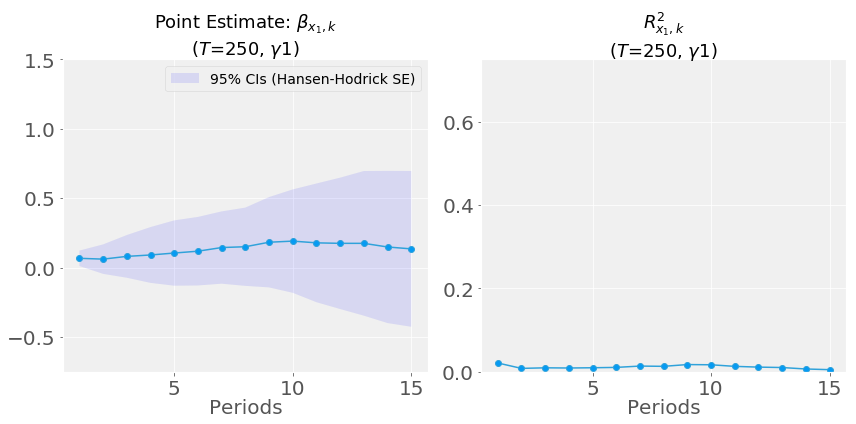

In [37]:
lhreg_table = lh_regressions(df_var2, row_T=250, x_col='x1', khorizon=15, 
                             lh_plot=True, z_known=True, fix_yscale=True) 

### Long-horizon regressions for $x_2$ for  $T=250$ and $\mathbf{\gamma}_1= (1, -1)^{\prime}$:
$$
\begin{align*}
    x_{2, t + 1} +  x_{2, t + 2} + ... + x_{2, t + k} = \mu_{x_{2}, k} + \beta_{x_{2}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

j = 1 : (T =250 , gamma = [0.  0.3] )

LH regressions for x2 :
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
    1         0.29     0.03  0.03    0.03    0.03   0.26
    2         0.41     0.03  0.04    0.04    0.04   0.37
    3         0.52     0.04  0.05    0.05    0.05   0.41
    4         0.63     0.04  0.06    0.06    0.06   0.43
    5         0.70     0.05  0.07    0.08    0.07   0.44
    6         0.80     0.05  0.08    0.08    0.08   0.48
    7         0.86     0.05  0.09    0.09    0.09   0.48
    8         0.94     0.06  0.09    0.10    0.09   0.50
    9         1.01     0.06  0.10    0.11    0.10   0.51
    10        1.04     0.06  0.11    0.11    0.11   0.48
    11        1.07     0.07  0.12    0.13    0.13   0.47
    12        1.09     0.07  0.13    0.14    0.14   0.45
    13        1.14     0.08  0.15    0.16    0.16   0.45
    14        1.15     0.09  0.17    0.18    0.18   0.42
    15        1.15     0.

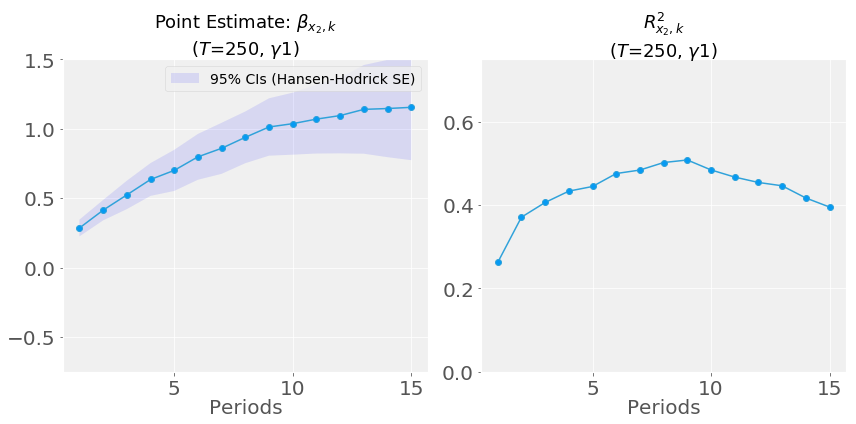

In [38]:
lhreg_table = lh_regressions(df_var2, row_T=250, x_col='x2', khorizon=15, 
                             lh_plot=True, z_known=True, fix_yscale=True) 

### Long-horizon regressions for $x_1$ for  $T=2500$ and $\mathbf{\gamma}_1= (1, -1)^{\prime}$:
$$
\begin{align*}
    x_{1, t + 1} +  x_{1, t + 2} + ... + x_{1, t + k} = \mu_{x_{1}, k} + \beta_{x_{1}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

j = 1 : (T =2500 , gamma = [0.  0.3] )

LH regressions for x1 :
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
    1         0.05     0.01  0.01    0.01    0.01   0.01
    2         0.05     0.01  0.02    0.02    0.02   0.00
    3         0.04     0.02  0.03    0.03    0.03   0.00
    4         0.02     0.02  0.03    0.04    0.04   0.00
    5         0.00     0.02  0.04    0.04    0.04   0.00
    6        -0.01     0.03  0.04    0.05    0.05   0.00
    7        -0.02     0.03  0.05    0.05    0.05   0.00
    8        -0.02     0.03  0.05    0.06    0.06   0.00
    9        -0.02     0.03  0.06    0.06    0.06   0.00
    10       -0.03     0.03  0.06    0.07    0.07   0.00
    11       -0.03     0.03  0.07    0.07    0.07   0.00
    12       -0.03     0.04  0.07    0.08    0.08   0.00
    13       -0.02     0.04  0.07    0.08    0.08   0.00
    14       -0.02     0.04  0.08    0.08    0.08   0.00
    15       -0.00     0

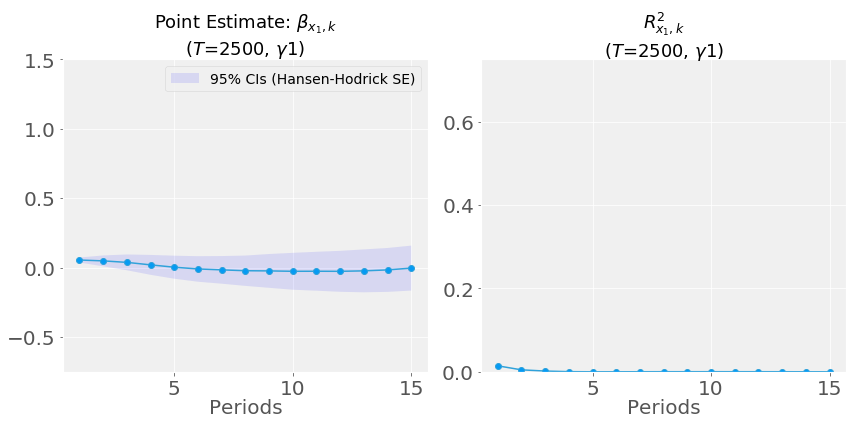

In [39]:
lhreg_table = lh_regressions(df_var2, row_T=2500, x_col='x1', khorizon=15, 
                             lh_plot=True, z_known=True, fix_yscale=True) 

### Long-horizon regressions for $x_2$ for  $T=2500$ and $\mathbf{\gamma}_1= (1, -1)^{\prime}$:
$$
\begin{align*}
    x_{1, t + 1} +  x_{1, t + 2} + ... + x_{1, t + k} = \mu_{x_{1}, k} + \beta_{x_{1}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

j = 1 : (T =2500 , gamma = [0.  0.3] )

LH regressions for x2 :
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
    1         0.29     0.01  0.01    0.01    0.01   0.27
    2         0.45     0.01  0.01    0.01    0.01   0.42
    3         0.60     0.01  0.02    0.02    0.02   0.49
    4         0.70     0.01  0.02    0.02    0.02   0.51
    5         0.78     0.02  0.02    0.03    0.03   0.51
    6         0.84     0.02  0.03    0.03    0.03   0.49
    7         0.89     0.02  0.03    0.03    0.03   0.46
    8         0.92     0.02  0.04    0.04    0.04   0.42
    9         0.93     0.02  0.04    0.04    0.04   0.39
    10        0.94     0.02  0.04    0.05    0.05   0.36
    11        0.95     0.03  0.05    0.05    0.05   0.33
    12        0.96     0.03  0.05    0.06    0.06   0.31
    13        0.97     0.03  0.06    0.06    0.06   0.29
    14        0.98     0.03  0.06    0.06    0.07   0.27
    15        0.99     0

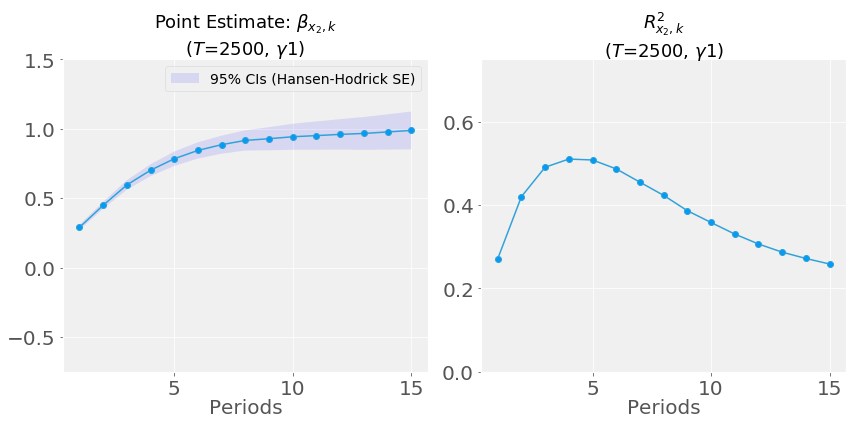

In [40]:
lhreg_table = lh_regressions(df_var2, row_T=2500, x_col='x2', khorizon=15, 
                             lh_plot=True, z_known=True, fix_yscale=True) 

#### Discussion: 
It can be shown that when the cointegrating residual $z_t$ is well-defined in terms of a **stationary** linear combination of $x_{1,t}$ and $x_{2,t}$, where one variable error-corrects (and the other doesn't), then $z_t$ has an AR($1$) representation with coefficient $\phi$. 

Furthermore, the $R^2$ function in terms of horizon $k$ (as shown in above plots) will also depend on $\phi$. The lower the $\phi$, the smaller the $k^*$ that maximizes  $R^2(k; \phi)$. This implies we see the "mean-reversion" much sooner. 

On the other hand, the larger the $\phi$ (but w/ $\mid \phi \mid < 1$ still), the larger the $k^*$ that maximizes  $R^2(k; \phi)$. This implies it takes a lot longer to see the "mean-reversion."

For example, compare the cases with $\gamma_1 = (0, 0.3)^{\prime}$ and $\gamma_2 = (0, 0.03)^{\prime}$. The first case yields the AR($1$) representation:

$$
\begin{align*}
z_t & =0.7 z_{t-1} + v_t \\
v_t & \sim i.i.d. WN\left(0,\sigma_v^2\right)
\end{align*}
$$

the latter yields

$$
\begin{align*}
z_t & =0.97 z_{t-1} + v_t \\
v_t & \sim i.i.d. WN\left(0,\sigma_v^2\right)
\end{align*}
$$

The plots shown in the previous cells confirm the intuition regarding the $\gamma_j$, implied $\phi$, the function $R^2(k; \phi)$, and the "mean-reverting" behavior.

## Part F:

Study the serial correlation patterns of the errors of the long-horizon regressions.

### Solution Part F:

Let's analyze the residuals from our long-horizon regressions, for $T=250, 2500$ and $\mathbf{\gamma}_1= (1, -1)^{\prime}$:

In [41]:
def plot_acf_residuals_lh(df_var2, row_T, x_col, lh_khorizon, acf_lags, z_known=True): 
    row_T_label = 'T=' + str(row_T)
    for j in range(0, len(gamma_vecm)):
        col_j = 'gamma' + str(j+1)
        
        x = df_var2.loc[row_T_label, col_j][0][x_col]
        if z_known==True:
            Z = df_var2.loc[row_T_label, col_j][0]['z']
        else:  
            if z_est=='ols':
                Z = df_var2.loc[row_T_label, col_j][0]['z_ols']
            else:
                Z = df_var2.loc[row_T_label, col_j][0]['z_dols']
        
        (_, _, _, _, _,_, ols_resids) = lh_reg(x=x, z=Z, k=lh_khorizon)
        
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))  
        sm.tsa.graphics.plot_acf(ols_resids, ax=axes, lags=acf_lags)
        if x_col=='x1':
            axes.set_title('${\it ACF}$ of residuals $u_{x_1, k}$\n ($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', 
                           fontsize=20)
        else:
            axes.set_title('${\it ACF}$ of residuals $u_{x_2, k}$\n ($T$=' + str(row_T) + ', $\gamma$' + str(j+1) + ')', 
                           fontsize=20)            
        axes.set_xlabel('Lags', fontsize=20)  
        
        fig.tight_layout()

### ACF of residuals from the following long-horizon regression (with $T=250$):  $\widehat{\rho}_{\widehat{u}_{k}}(j)$
$$
\begin{align*}
    x_{1, t + 1} +  x_{1, t + 2} + ... + x_{1, t + k} = \mu_{x_{1},k} + \beta_{x_{1}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

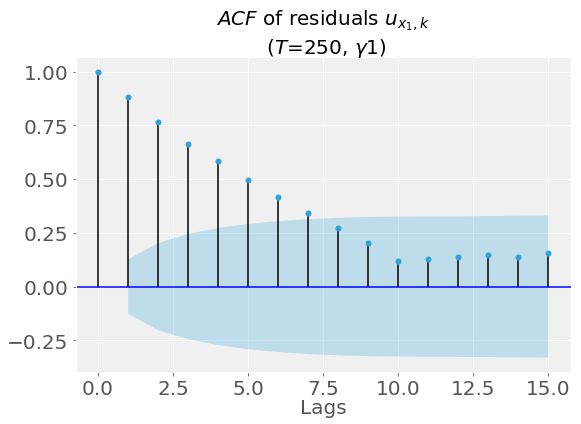

In [42]:
### ACF of residuals from long-horizon regressions for T=250 and "x1"
plot_acf_residuals_lh(df_var2, row_T=250, x_col='x1', 
                      lh_khorizon=10, acf_lags=15, z_known=True)

### ACF of residuals from the following long-horizon regression (with $T=2500$):  $\widehat{\rho}_{\widehat{u}_{k}}(j)$
$$
\begin{align*}
    x_{1, t + 1} +  x_{1, t + 2} + ... + x_{1, t + k} = \mu_{x_{1}, k} + \beta_{x_{1}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

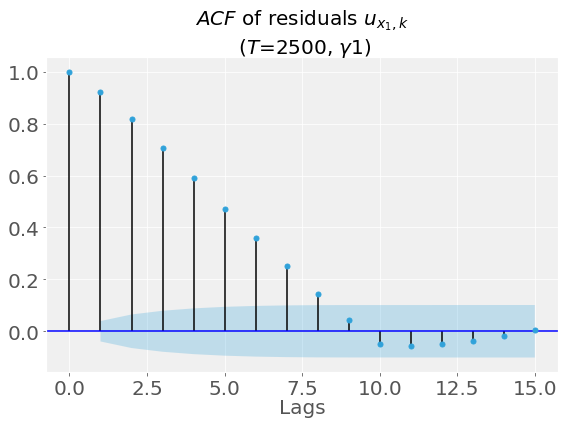

In [43]:
### ACF of residuals from long-horizon regressions for T=2500 and "x1"
plot_acf_residuals_lh(df_var2, row_T=2500, x_col='x1', 
                      lh_khorizon=10, acf_lags=15, z_known=True)

### ACF of residuals from the following long-horizon regression (with $T=250$):  $\widehat{\rho}_{\widehat{u}_{k}}(j)$
$$
\begin{align*}
    x_{2, t + 1} +  x_{2, t + 2} + ... + x_{2, t + k} = \mu_{x_{2}, k} + \beta_{x_{2}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

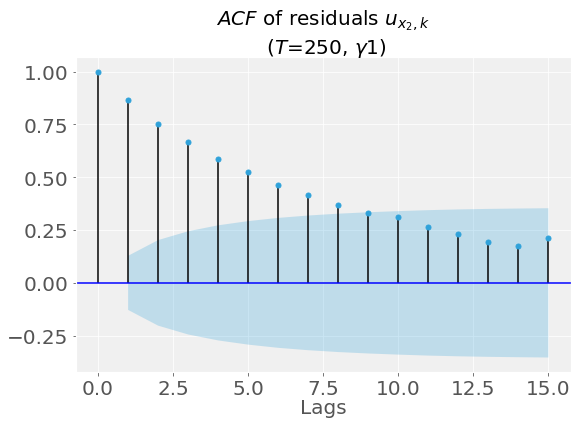

In [44]:
### ACF of residuals from long-horizon regressions for T=250 and "x2"
plot_acf_residuals_lh(df_var2, row_T=250, x_col='x2', 
                      lh_khorizon=15, acf_lags=15, z_known=True)

### ACF of residuals from the following long-horizon regression (with $T=2500$):  $\widehat{\rho}_{\widehat{u}_{k}}(j)$
$$
\begin{align*}
    x_{2, t + 1} +  x_{2, t + 2} + ... + x_{2, t + k} = \mu_{x_{2}, k} + \beta_{x_{2}, k}\cdot z_t + u_{t+k, k}
\end{align*}    
$$

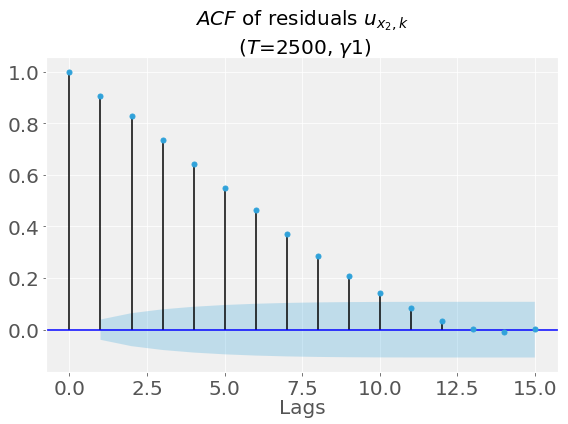

In [45]:
### ACF of residuals from long-horizon regressions for T=2500 and "x2"
plot_acf_residuals_lh(df_var2, row_T=2500, x_col='x2', 
                      lh_khorizon=15, acf_lags=15, z_known=True)

# Example 2: $\widehat{cay}$

We will now construct a measure of short-term deviations from a **long-run cointegration relationship** among the logarithm of consumption ($c$), labor income ($y$), and aggregate wealth ($a$) i.e. $\widehat{cay}$, from **Lettau and Ludvigson (2001, 2004)**.

We will utilize versions of the functions we used in **Example 1** (with some adjustments since we know have 3 variables instead of 2).

First, let's read in the relevant dataset. The observed variables of interest are primarily sourced from the U.S. Bureau of Economic Analysis (BEA), and transformed from levels to natural logs. They are denoted $c_t$, $a_t$, and $y_t$. 

* $c_t=log(C_t)$ is the log of <u>consumption *flow*</u>, measured using real, per capita, expenditures on non-durables and services (excluding shoes and clothing).
* $a_t=log(A_t)$ is the log of <u>asset wealth</u>, measured using real, per capita household net worth, which includes all financial wealth, housing wealth, and consumer durables.
* $a_t=log(A_t)$ is the log of (after-tax) <u>labor income</u> measured in real, per capita terms.

In [46]:
### Import dataset (with log transformations)
df = pd.read_csv('CAY.csv',index_col='date', parse_dates=True)
df.index = pd.to_datetime(df.index, format="%Y%m") + MonthEnd(0)

print(df.info(), '\n')
display(multi_table([df.head(), df.tail()]))

Y = df[['c','a','y']]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206 entries, 1951-04-30 to 2003-01-31
Data columns (total 4 columns):
c      206 non-null float64
a      206 non-null float64
y      206 non-null float64
cay    206 non-null float64
dtypes: float64(4)
memory usage: 8.0 KB
None 



,c,a,y,cay
date,,,,
1951-04-30,8.946,10.563,8.658,0.005
1952-01-31,8.944,10.571,8.666,-0.003
1952-02-29,8.957,10.583,8.667,0.006
1952-03-31,8.967,10.578,8.682,0.007
1952-04-30,8.975,10.575,8.711,-0.001
,c,a,y,cay
date,,,,
2002-01-31,9.960,11.781,9.793,-0.013
2002-02-28,9.962,11.743,9.801,-0.005


### Summary of long-term relationship between $c_t$,  $a_t$,  and $y_t$:

Let's start with an aggregate economy (like that of the U.S.) and assume that all wealth (including human capital i.e. labor income) is tradable. Let's define the following variables:
* $W_t$ is aggregate wealth (human capital i.e. labor income plus financial asset holdings)
* $C_t$ is consumption 
* $R_{w,t+1}$ is the <u>net</u> return on aggregate wealth. 

Consider the budget-constraint $W_{t+1} = (1 + R_{w,t+1})(W_{t} - C_{t})$. This gives us a dynamic relationship for how wealth accumulates over time.

Under the assumption that consumption-wealth ratio is $I(0)$, we can approximate the budget-constraint using a $1^{st}$-order Taylor approximation around steady-state:

$$
\begin{align*}
 \Delta w_t \approx k + r_{w, t+1} + \left(1 - \frac{1}{\rho_{w}} \right)(c_t - w_t)
\end{align*}
$$

where $\rho_{w}$ = steady-state ratio of $ \left( \frac{W_t - C_t}{W_t} \right)$ and $k$ = constant resulting from the Taylor expansion (plays no role, just like the constant in the **Campbell and Shiller (1988) decomposition** we saw in lecture).

We iterate forward and only make the assumption that 

$$
\begin{align*}
  \lim_{i \to \infty} \rho_w^i\left(c_{t+i} - w_{t+i}\right) = 0  
\end{align*}
$$

resulting in the **log-linear approximation to the consumption-wealth ratio**: 

$$
\begin{align*}
  c_t - w_t =  \sum_{i=1}^{\infty}  \rho_w^i \left( r_{w, t+i} - \Delta c_{t+i} \right)
\end{align*}
$$

which is an ex-post dynamic relationship that will also hold ex-ante (i.e. in *expectation*): 

$$
\begin{align*}
  c_t - w_t =  E_t \left[\sum_{i=1}^{\infty}  \rho_w^i \left( r_{w, t+i} - \Delta c_{t+i} \right) \right]
\end{align*}
$$

The **left-hand side** shows that the consumption-wealth ratio, $(c_t - w_t)$, can vary if:
1. expected consumption growth, or
2. expected wealth returns, or
3. both

are **forecastable**. 

Aggregate wealth $W$ will be approximated as $W_t = A_t + H_t$ where $A_t$ is financial wealth and $H_t$ is non-financial wealth (i.e. human capital). 

$H_t$ will in turn be described by labor income $Y_t$ via the relation $log(H_t) = \kappa + log(Y_t) + z_t$, where $\kappa$ is a constant and $z_t$ is simply a mean-zero $I(0)$ error term. The net return on financial wealth and non-financial wealth will be denoted by $R_{a,t}$ and $R_{h,t}$, respectively.

In logarithms, we have:

$$
\begin{align*}
  w_t \approx \omega a_t + (1 - \omega)h_t
\end{align*}
$$

where $\omega$ = average share of financial wealth in total wealth, $E\left[ \frac{A_t}{W_t} \right]=\frac{A}{W}$. 

This implies a log return decomposition for $R_{w,t}$ of:

$$
\begin{align*}
  r_{w,t} \approx \omega r_{a,t} + (1 - \omega)r_{h,t}
\end{align*}
$$

After making substitutions, the **log-linear approximation to the consumption-wealth ratio** has form:

$$
\begin{align*}
  c_t - \omega a_t - (1 - \omega)y_t & =  
  E_t \left[ \sum_{i=1}^{\infty} \rho_w^i \left( \right[\omega r_{a, t+i} + (1 - \omega) r_{h, t+i} \left]- \Delta c_{t+i} \right)\right] + (1 - \omega)z_t \\
  \text{w/} \;\rho_w & = \frac{(W - C)}{W}
\end{align*}
$$

which can be compared to the famous **Campbell and Shiller (1988)** decomposition of the log dividend-price ratio:

$$
\begin{align*}
  d_t - p_t & =  E_t \left[ \sum_{j=1}^{\infty} \rho_a^j \left(  r_{a, t+j} - \Delta d_{t+j} \right) \right]\\
  \text{w/} \;\rho_a & = \frac{P}{(P + D)}
\end{align*}
$$

### Key Implications:

Under the premise that all terms on the right-hand side of **log-linear approximation to the consumption-wealth ratio** are $I(0)$, then $c_t$, $a_t$, and $y_t$ will be **COINTEGRATED**

The left-hand side, $c_t - \omega a_t - (1 - \omega)y_t$ is the deviation in the common trend of $c_t$, $a_t$, and $y_t$. This trend deviation is defined as:

$$
\begin{align*}
  cay_t =  c_t - \omega a_t - (1 - \omega)y_t
\end{align*}
$$

and its estimate is precisely $\widehat{cay}_t$. 

Why is $cay_t$ important? In the **long-run**, it should help forecast financial asset returns $r_{a,t+i}$ 

### Testing for unit-roots:

Let's run a unit-root on $c_t$, $a_t$, and $y_t$ with a constant as well as with and without a time trend:

In [47]:
### No time-trend
adf_result_c = sm.tsa.stattools.adfuller(df['c'])
print('c_t: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result_c[0], adf_result_c[1]), 
      '\n\tcritical values:', adf_result_c[4], '\n')

adf_result_a = sm.tsa.stattools.adfuller(df['a'])
print('a_t: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result_a[0], adf_result_a[1]),
      '\n\tcritical values', adf_result_a[4], '\n')

adf_result_y = sm.tsa.stattools.adfuller(df['y'])
print('y_t:  ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result_y[0], adf_result_y[1]),
     '\n\tcritical values', adf_result_y[4], '\n\n')

c_t: ADF statistic (p-value): -1.683 (0.440) 
	critical values: {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515} 

a_t: ADF statistic (p-value): -0.647 (0.860) 
	critical values {'1%': -3.4626576734812318, '5%': -2.8757444215841326, '10%': -2.5743412314098753} 

y_t:  ADF statistic (p-value): -1.630 (0.468) 
	critical values {'1%': -3.4626576734812318, '5%': -2.8757444215841326, '10%': -2.5743412314098753} 




In [48]:
### Time-trend
adf_result_c = sm.tsa.stattools.adfuller(df['c'], regression='ct')
print('c_t: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result_c[0], adf_result_c[1]), 
      '\n\tcritical values:', adf_result_c[4], '\n')

adf_result_a = sm.tsa.stattools.adfuller(df['a'], regression='ct')
print('a_t: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result_a[0], adf_result_a[1]),
      '\n\tcritical values', adf_result_a[4], '\n')

adf_result_y = sm.tsa.stattools.adfuller(df['y'], regression='ct')
print('y_t:  ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result_y[0], adf_result_y[1]),
     '\n\tcritical values', adf_result_y[4], '\n\n')

c_t: ADF statistic (p-value): -1.478 (0.837) 
	critical values: {'1%': -4.004997848936356, '5%': -3.4327862452981046, '10%': -3.140144918368515} 

a_t: ADF statistic (p-value): -2.526 (0.315) 
	critical values {'1%': -4.0036234899377545, '5%': -3.4321268670216623, '10%': -3.139758677471308} 

y_t:  ADF statistic (p-value): -1.104 (0.928) 
	critical values {'1%': -4.0036234899377545, '5%': -3.4321268670216623, '10%': -3.139758677471308} 




For all 3 variables, we fail to reject the null hypothesis $\mathbf{H}_0$ of a unit root (at the 1%, 5%, and 10% significance levels) with or without the inclusion of a time trend. Hence $c_t$, $a_t$, and $y_t$ are **nonstationary**.

### Econometric Analysis:

Let's run the **Johansen (1991)** test for cointegration on $c_t$,  $a_t$,  and $y_t$. It is a procedure for testing cointegration of any $k$, $I(1)$ time series. This test permits more than one cointegrating relationship. In our case, $k=3$.

Thus, the **Johansen (1991)** test is generally more applicable than the **Augmented Engle–Granger two-step** test which is based on the **Augmented Dickey–Fuller** test for unit roots in the residuals from a single (estimated) cointegrating relationship. 

There are two types of Johansen test, either with <u>trace</u> or with <u>eigenvalue</u> (inferences may be a little bit different). 

#### Trace test:
The null hypothesis $\mathbf{H}_0$ for the <u>trace test</u> is that the number of cointegration vectors is $r = r^* < k$, vs. the alternative $\mathbf{H}_1:r = k$. Testing proceeds sequentially for $r^* = 1,2,...$, and the first non-rejection of the null is taken as an estimate of $r$. 

#### Eigenvalue test:
The null hypothesis $\mathbf{H}_0$ for the <u>"maximum eigenvalue" test</u> is as for the trace test but the alternative $\mathbf{H}_1:r = r^* + 1$ and, again, testing proceeds sequentially for $r^* = 1,2,...$, with the first non-rejection used as an estimator for $r$.

We will use the `statsmodels` routine [`coint_johansen`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html) that is a built-in function as part of the `VECM` class. We will include a constant term (i.e.`det_order=0`) and specify up to 2 lagged differences in the model (` k_ar_diff=2`). 

In [49]:
johan_test = coint_johansen(endog=Y, det_order=0,  k_ar_diff=2)
print('Trace = ',johan_test.lr1, '\ncv =\n ', johan_test.cvt)
print('\n\nMaxEV = ',johan_test.lr2, '\ncv =\n', johan_test.cvm)

Trace =  [20.5794   4.9687   0.92361] 
cv =
  [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


MaxEV =  [15.6107   4.04509  0.92361] 
cv =
 [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


The output above provides us with <u>trace test</u> statistics as well as the <u>"maximum eigenvalue" test</u> statistics, each at $1\%$, $5\%$, and $10\%$ critical values.

The <u>trace test</u> tells us we cannot reject the null hypothesis of one cointegrating relationship against the alternative of two or three. Whereas the <u>"maximum eigenvalue" test</u> tells us we may reject the null of no cointegration against the alternative of one cointegrating vector. 

Hence, **both tests establish evidence of cointegration** among $c_t$, $a_t$, and $y_t$.

Let's now estimate the cointegrating vector $\gamma = (1, \omega, 1 - \omega)$ for variables $(c_t, a_t, y_t)$ using **Dynamic OLS**. We do this since simply using **OLS** gives us consistent, but inefficient estimates. Using leads and lags as discussed before helps with inefficiency.

Let's use 8 leads and lags of the first differences of $\Delta y_t$ and $\Delta a_t$ as the authors did in their paper.

In [50]:
def dols_cointegrating_vec(df_y, df_x, k_lags, incl_trend=False):
    df_dx = df_x.diff(1)
    XX = df_x
    for klag in range(1,k_lags):
        xl = df_dx.shift(klag)
        xl.columns = [l + str(klag) for l in xl.columns]
        XX = pd.concat([XX, xl], axis=1)
        xl = df_dx.shift(-klag)
        xl.columns = [l + str(-klag) for l in xl.columns]
        XX = pd.concat([XX, xl], axis=1)
    XX = XX.iloc[k_lags:-k_lags+1]
    Y  = df_y.iloc[k_lags:-k_lags+1]
    dols_fit = sm.OLS(Y,sm.add_constant(XX), missing='drop').fit()
    dols_fit = dols_fit.get_robustcov_results(cov_type='HAC',maxlags=k_lags)
    return dols_fit

def get_cointegrating_vec(x1, x2, alpha, remove_trend=False):
    """
    Get cointegrating error "z" from alpha, 
    and check for unit root
    """
    print('Cointegrating vector: ', alpha)
    X = np.c_[x1, x2]
    z = np.dot(X, alpha)
    if remove_trend:
        T = np.array(range(z.shape[0]))
        z = sm.OLS(z, sm.add_constant(T)).fit().resid
    ### Check for unit root
    adf_result = sm.tsa.stattools.adfuller(z)
    print('\nADF stat (p-val): %0.3f (%0.3f)' % (adf_result[0], adf_result[1]), 
         '\n\tcritical values:', adf_result[4], '\n')
    return z

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4408.
Date:                Sat, 18 May 2019   Prob (F-statistic):          6.54e-218
Time:                        03:20:33   Log-Likelihood:                 632.59
No. Observations:                 191   AIC:                            -1203.
Df Residuals:                     160   BIC:                            -1102.
Df Model:                          30                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7390      0.063     11.781      0.0

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


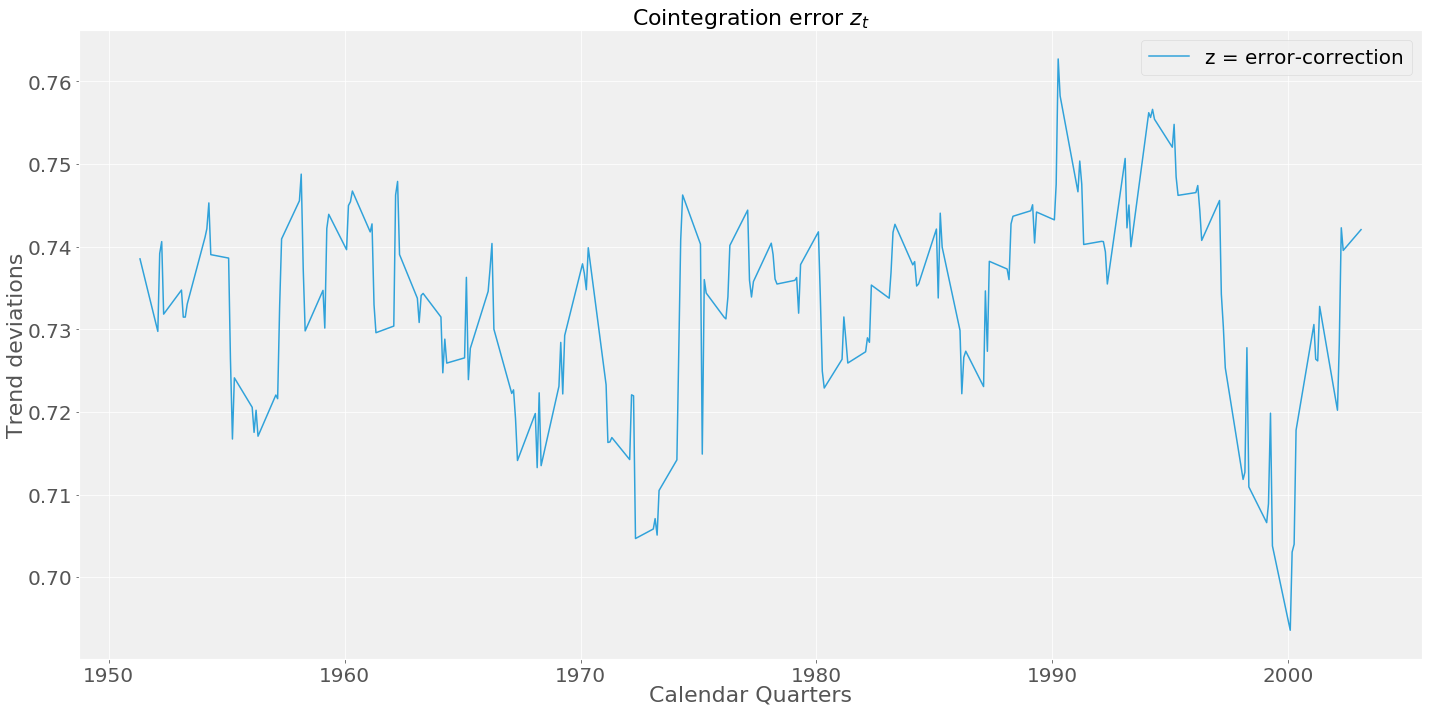

In [51]:
### gamma from DOLS
x  = df[['c','a','y']]
x1 = df[['c']]
x2 = df[['a','y']]

dols_fit = dols_cointegrating_vec(x1, x2, k_lags=8, incl_trend=False)
print(dols_fit.summary(),'\n')

gamma_dols = np.array([1, -dols_fit.params[1] , -dols_fit.params[2]])
z_dols = pd.DataFrame(get_cointegrating_vec(x1, x2, gamma_dols, remove_trend=False), index=df.index)
z_dols.index   = df.index
z_dols.columns = ['ec']

df['ec_dols'] = z_dols

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))        
axes.plot(z_dols['ec'], label='z = error-correction')
axes.set_title('Cointegration error $z_t$', fontsize=22)
axes.set_xlabel('Calendar Quarters', fontsize=22)
axes.set_ylabel('Trend deviations', fontsize=22)
axes.legend(fontsize=20)
fig.tight_layout()
    

The **Dynamic OLS** procedure provides us with: ${\widehat{\mathbf\alpha}_{DOLS}}\approx(1, -0.26, -0.64)$

Let's now estimate the VECM($1$) associated with this model:

$$
\begin{align*}
    \Delta \mathbf{X}_t & = \mathbf{\nu} + \mathbf{\gamma} \mathbf{\widehat{\alpha}}^{\prime} \mathbf{X}_{t-1} + 
    \mathbf{\Gamma}(L)\Delta \mathbf{X}_{t-1} + \mathbf{\epsilon}_t\\[3mm]
    \Delta \mathbf{X}_t &= 
    \begin{pmatrix}
        \Delta c_t \\ \Delta a_t \\ \Delta y_t  
    \end{pmatrix},\;
    \mathbf{\nu} = 
    \begin{pmatrix}
        \nu_1 \\ \nu_2 \\ \nu_3 
    \end{pmatrix},\;
    \mathbf{\gamma} = 
    \begin{pmatrix}
        \gamma_c \\ \gamma_a \\ \gamma_y 
    \end{pmatrix}\;    
\end{align*}
$$

where $\Delta \mathbf{X}_t$ is the $(3 \times 1)$ vector of log first differences, $\mathbf{\nu}$  is the $(3 \times 1)$ vector of constants, and $\mathbf{\gamma}$ is the  $(3 \times 1)$ vector of cointegrating coefficients, which provide us information on which variables error-correct, and which don't. Also, $\mathbf{\Gamma}(L)$ is a $(3 \times 3)$ a finite-order distributed lag operator (here $L=1$), and 
$$
\begin{align*}
    \mathbf{\widehat{\alpha}}{\prime} = 
    \begin{pmatrix}
        1 \\ \widehat{\alpha}_a \\ \widehat{\alpha}_y 
    \end{pmatrix}
\end{align*}
$$    
is  the $(3 \times 1)$ vector of previously estimated cointegrating coefficients via **Dynamic OLS**. 

We will use the `statsmodels` routine [`VECM`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.VECM.html) as well as our "brute-force" VECM function from **Example 1**.

In [52]:
### VECM: equation-by-equation OLS, including "true" cointegrating error
def vecm_ols_eq(df_endog, df_ec, k_lags, incl_trend=False):
    
    df_endog.columns = ['d_' + col for col in df_endog.columns]
    df_Xtilde = df_endog.copy()
    
    for col in df_endog.columns:
        df_Xtilde.loc[:, col] = df_endog[col].diff(1)
    
    for col in df_ec.columns:
        df_Xtilde.loc[:, 'L1_' + col] = df_ec[col].shift(1)
    
    for col in df_endog.columns:
        for klag in range(1, k_lags + 1):
            df_Xtilde.loc[:, 'L' + str(klag) + '_' + col] = df_endog[col].shift(klag)  
    
    if incl_trend:
        df_Xtilde['trend'] = np.array(range(df_endog.shape[0]))
    
    XX_idx = df_endog.shape[1] + df_ec.shape[1] - 1
    XX = df_Xtilde.iloc[:, XX_idx:]
    
    df_vecm_olseq = pd.DataFrame(columns=df_endog.columns, index=[0])
    for col in df_endog.columns:
        vecm_olseq_fit = sm.OLS(df_Xtilde[col], sm.add_constant(XX), missing='drop').fit()       
        df_vecm_olseq[col] = vecm_olseq_fit
    
    return  df_vecm_olseq


In [53]:
### "brute-force" VECM(1) estimation via OLS equation-by-equation
df_endog = df[['c', 'a', 'y']]
df_ec = df[['ec_dols']] 
k_lags = 1
df_vecm_olseq = vecm_ols_eq(df_endog, df_ec, k_lags=k_lags, incl_trend=False)

gamma_vecm_est    = np.empty([1, df_endog.shape[1]])
gamma_vecm_est_se = np.empty([1, df_endog.shape[1]])
gamma_vecm_est_tstat = np.empty([1, df_endog.shape[1]])
for col in df_endog.columns:
    print('variable ' + col + ': \n',  df_vecm_olseq.loc[0, col].summary(), '\n')
    
    gamma_vecm_eqest    = df_vecm_olseq.loc[0, col].params[1]
    gamma_vecm_eqest_se = df_vecm_olseq.loc[0, col].bse[1]
    gamma_vecm_eqest_tstat = gamma_vecm_eqest/gamma_vecm_eqest_se
    
    idx = df_endog.columns.get_loc(col)
    gamma_vecm_est[0, idx]    = gamma_vecm_eqest.item()
    gamma_vecm_est_se[0, idx] = gamma_vecm_eqest_se.item()
    gamma_vecm_est_tstat[0, idx] = gamma_vecm_eqest_tstat.item()
    
print('VECM: estimated gamma = \n(', gamma_vecm_est.flat[:], ')\n')
print('VECM: estimated gamma SEs = \n(', gamma_vecm_est_se.flat[:], ')\n')
print('VECM: estimated gamma t-stat = \n(', gamma_vecm_est_tstat.flat[:], ')\n\n\n')


variable d_c: 
                             OLS Regression Results                            
Dep. Variable:                    d_c   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     4.076
Date:                Sat, 18 May 2019   Prob (F-statistic):            0.00774
Time:                        03:20:33   Log-Likelihood:                 814.32
No. Observations:                 205   AIC:                            -1621.
Df Residuals:                     201   BIC:                            -1607.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0725      0.024    

In [54]:
### "statsmodels" estimation of VECM(1)
vecm_model = VECM(Y, k_ar_diff=1, coint_rank=1, deterministic='co').fit()
gamma_vecm_statsmodels = vecm_model.alpha
alpha_vecm_statsmodels = vecm_model.beta

print("Estimated gamma : ", gamma_vecm_statsmodels.flat[:])
print("Estimated alpha : ", alpha_vecm_statsmodels.flat[:], '\n')
print(vecm_model.summary(), '\n')

Estimated gamma :  [-0.03945  0.38467  0.00642]
Estimated alpha :  [ 1.      -0.26345 -0.62414] 

Det. terms outside the coint. relation & lagged endog. parameters for equation c
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0332      0.020      1.663      0.096      -0.006       0.072
L1.c           0.2033      0.075      2.694      0.007       0.055       0.351
L1.a           0.0426      0.016      2.727      0.006       0.012       0.073
L1.y           0.0659      0.040      1.656      0.098      -0.012       0.144
Det. terms outside the coint. relation & lagged endog. parameters for equation a
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2856      0.090     -3.156      0.002      -0.463      -0.108
L1.c           0.0673      0.

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Albeit the point estimates of $\gamma$ differ quantitatively between the `statsmodels` VECM and our "brute-force" **OLS** routine, they are qualitatively similar. 

Taking the `statsmodels` VECM estimates as valid, the estimated loadings on the cointegrating error $\widehat{cay}_t$ are: 
$$
\gamma_{statsmodels} = (-0.040, 0.385, 0.010)
$$ 

* The "brute-force" OLS estimates are $\gamma_{OLS} = (-0.044, 0.221, 0.013)$. 

One noticeable difference is that although the loading on $\widehat{cay}_t$ in the $\Delta a_t$ regression is statistically significant at the 5% significance level in both routines, it is only statistically significant at the 5% level in the $\Delta c_t$ regression when using our OLS code. This suggests our standard errors are potentially too restrictive (i.e. homoskedasticity is not a valid assumption).

Let's alter the functions from before that displayed and plotted estimates from **long-horizon regressions**:

In [55]:
def long_horizon_regs(x, z, k_horizon=10):
    lh_table = np.empty((k_horizon, 7))
    for k in range(k_horizon):
        lh_table[k,0] = k+1
        (beta_hat, se_r, se_nw, se_hh1, se_hh2, r2, _) = lh_reg(x, z, k+1)
        lh_table[k,1] = beta_hat
        lh_table[k,2] = se_r
        lh_table[k,3] = se_nw
        lh_table[k,4] = se_hh1
        lh_table[k,5] = se_hh2
        lh_table[k,6] = r2
    headers = ['Horizon k', 'Est: beta_k', 'SE(r)', 'SE(nw)', 'SE(hh1)', 'SE(hh2)', 'R2']
    tbl = sm.iolib.table.SimpleTable(lh_table, headers,
          data_fmts=['%d', '%0.2f', '%0.2f', '%0.2f', '%0.2f', '%0.2f',' %0.2f'] )
    print(tbl, '\n\n\n')
    return lh_table

In [56]:
def cay_lh_regressions(df, x_col, khorizon, lh_plot=True, cay_est=None, fix_yscale=True): 

    df['d'+ x_col] = df[x_col].diff()
    df  = df.dropna(axis=0)
    lhs = df['d'+ x_col].values
    if cay_est=='ols':
        cay = df['ec_ols'].values
    else:
        cay = df['ec_dols'].values

    print('LH regressions for ' + str(x_col), ':')
    lhreg_table = long_horizon_regs(x=lhs, z=cay, k_horizon=khorizon)

    if lh_plot==True:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        if fix_yscale==True:
            axes[0].set_ylim([-0.25, 1.25])
            axes[1].set_ylim([0, 0.2])

        axes[0].plot(lhreg_table[:,0], lhreg_table[:,1], marker='o', markerfacecolor='xkcd:azure')
        axes[0].fill_between(x=lhreg_table[:,0], 
                             y1=lhreg_table[:,1] - 1.96*lhreg_table[:,4], 
                             y2=lhreg_table[:,1] + 1.96*lhreg_table[:,4], 
                             facecolor='blue', alpha=0.1, label='95% CIs (Hansen-Hodrick SE)')
        axes[1].plot(lhreg_table[:,0], lhreg_table[:,6], marker='o', markerfacecolor='xkcd:azure')

        if x_col=='c':
            axes[0].set_title('Point Estimate: $\\beta_{\Delta c, H}$', fontsize=18)                          
            axes[1].set_title('$R^2_{\Delta c, H}$', fontsize=22)            
        elif x_col=='y':
            axes[0].set_title('Point Estimate: $\\beta_{\Delta y, H}$', fontsize=18)
            axes[1].set_title('$R^2_{\Delta y, H}$', fontsize=22)  
        elif x_col=='a':
            axes[0].set_title('Point Estimate: $\\beta_{\Delta a, H}$', fontsize=18)
            axes[1].set_title('$R^2_{\Delta a, H}$', fontsize=22)              
        
        axes[0].set_xlabel('Quarters', fontsize=20)
        axes[1].set_xlabel('Quarters', fontsize=20)
        axes[0].legend(fontsize=14, loc='best')
        fig.tight_layout()


### Long-horizon regressions for $\Delta c_t$:

Let's estimate long-horizon regressions for $\Delta c_t$:

$$
\begin{align*}
    \Delta c_{t + 1} + ... + \Delta c_{t + H} = \mu_{{\Delta c}, H} + \beta_{{\Delta c}, H}\cdot z_{t} + u^{\Delta c}_{t+H, H}
\end{align*}    
$$

where $z_{t}=\widehat{\mathbf{\alpha}}_t^{\prime}\mathbf{X_t}$

LH regressions for c :
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
    1        -0.01     0.03  0.03    0.03    0.03   0.00
    2         0.03     0.04  0.03    0.04    0.03   0.00
    3         0.04     0.03  0.04    0.04    0.03   0.01
    4         0.05     0.03  0.04    0.05    0.04   0.01
    5         0.07     0.04  0.04    0.04    0.02   0.02
    6         0.07     0.03  0.04    0.02    0.01   0.02
    7         0.07     0.03  0.04    0.02    0.01   0.02
    8         0.08     0.04  0.04    0.03    0.02   0.02
    9         0.05     0.04  0.04    0.03    0.03   0.01
    10        0.04     0.03  0.05    0.04    0.03   0.01
    11        0.06     0.04  0.04    0.03    0.03   0.01
    12        0.06     0.04  0.05    0.04    0.04   0.01
    13        0.07     0.04  0.05    0.05    0.05   0.01
    14        0.07     0.04  0.05    0.05    0.05   0.02
    15        0.06     0.04  0.05    0.05    0.05   0.01
--------

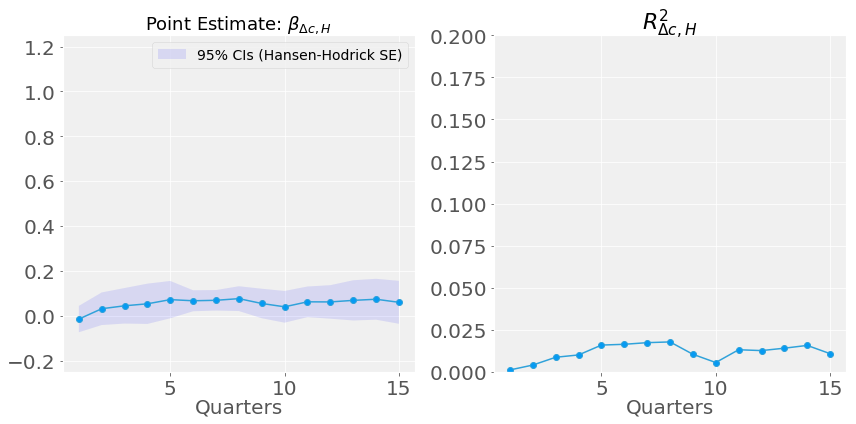

In [57]:
cay_lhreg_table = cay_lh_regressions(df, x_col='c', khorizon=15, lh_plot=True, 
                                     cay_est='dols', fix_yscale=True)

#### Discussion:

The **long-horizon regressions** indicate that consumption growth $\Delta c_t$ is not really predictable by $\widehat{cay}_t$, which is our cointegrating error. The point estimate $\beta_{\Delta c, H}$ is indistinguishable from zero at almost every horizon. 

### Long-horizon regressions for $\Delta y_t$:

Let's estimate long-horizon regressions for $\Delta y_t$:

$$
\begin{align*}
    \Delta y_{t + 1} + ... + \Delta y_{t + H} = \mu_{{\Delta y}, H} + \beta_{{\Delta y}, H}\cdot z_{t} + u^{\Delta y}_{t+H, H}
\end{align*}    
$$


where $z_{t}=\widehat{\mathbf{\alpha}}_t^{\prime}\mathbf{X_t}$

LH regressions for y :
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
    1         0.25     0.07  0.07    0.07    0.06   0.06
    2         0.27     0.06  0.07    0.07    0.06   0.07
    3         0.25     0.07  0.07    0.08    0.06   0.06
    4         0.26     0.07  0.07    0.08    0.06   0.06
    5         0.25     0.09  0.07    0.08    nan    0.05
    6         0.22     0.08  0.07    0.06    0.03   0.05
    7         0.22     0.10  0.07    0.05    nan    0.04
    8         0.22     0.09  0.07    0.05    0.03   0.05
    9         0.17     0.09  0.06    0.04    0.02   0.03
    10        0.19     0.08  0.05    0.04    nan    0.04
    11        0.25     0.09  0.06    0.05    0.04   0.06
    12        0.26     0.07  0.06    0.04    0.02   0.06
    13        0.19     0.08  0.07    0.08    0.06   0.03
    14        0.26     0.08  0.07    0.07    0.04   0.06
    15        0.25     0.09  0.07    0.07    0.04   0.05
--------

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1602: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


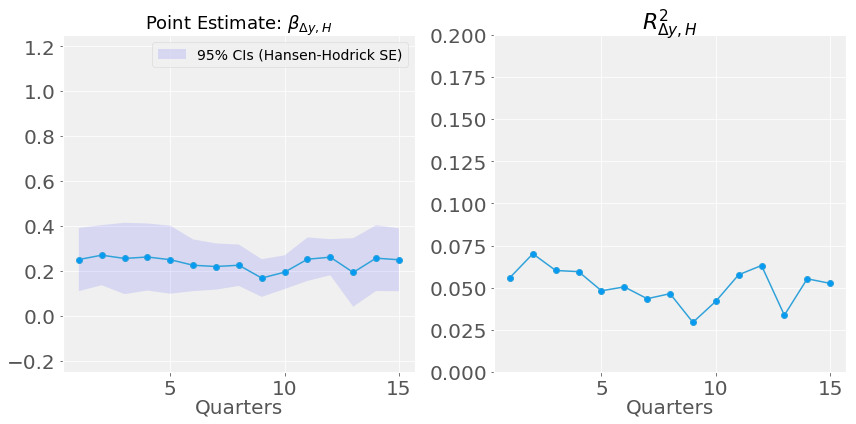

In [58]:
cay_lhreg_table = cay_lh_regressions(df, x_col='y', khorizon=15, lh_plot=True, 
                                     cay_est='dols', fix_yscale=True)

#### Discussion:

The **long-horizon regressions** indicate that labor income growth $\Delta y_t$ is also slightly predictable by $\widehat{cay}_t$. The point estimate $\beta_{\Delta y, H}$ is distinguishable from zero at most horizons, but the estimates are not economically significant. Moreover, the $R^2$'s are close to zero. 

### Long-horizon regressions for $\Delta a_t$:

Let's estimate long-horizon regressions for $\Delta a_t$:

$$
\begin{align*}
    \Delta a_{t + 1} + ... + \Delta a_{t + H} = \mu_{{\Delta a}, H} + \beta_{{\Delta a}, H}\cdot z_{t} + u^{\Delta a}_{t+H, H}
\end{align*}    
$$


where $z_{t}=\widehat{\mathbf{\alpha}}_t^{\prime}\mathbf{X_t}$

LH regressions for a :
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
    1         0.64     0.16  0.12    0.16    0.06   0.08
    2         0.63     0.18  0.13    0.13    nan    0.07
    3         0.53     0.16  0.14    0.15    0.07   0.06
    4         0.61     0.20  0.17    0.20    0.09   0.07
    5         0.59     0.20  0.17    0.15    0.04   0.06
    6         0.58     0.20  0.17    0.14    0.02   0.07
    7         0.62     0.21  0.17    0.11    0.08   0.07
    8         0.63     0.18  0.19    0.20    0.17   0.08
    9         0.62     0.19  0.21    0.21    0.20   0.08
    10        0.64     0.19  0.21    0.19    0.18   0.08
    11        0.65     0.22  0.23    0.19    0.21   0.07
    12        0.59     0.18  0.21    0.20    0.21   0.07
    13        0.61     0.21  0.27    0.26    0.27   0.06
    14        0.54     0.20  0.21    0.18    0.21   0.04
    15        0.38     0.18  0.19    0.18    0.21   0.03
--------

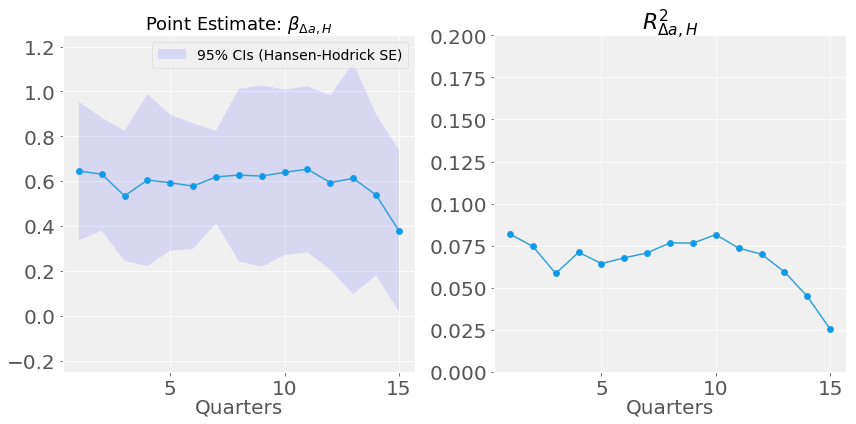

In [59]:
cay_lhreg_table = cay_lh_regressions(df, x_col='a', khorizon=15, lh_plot=True, 
                                     cay_est='dols', fix_yscale=True)

#### Discussion:

The **long-horizon regressions** indicate that asset wealth growth $\Delta a_t$ is the only variable in the cointegrating relationship that is somewhat predictable at any horizon. The point estimate $\beta_{\Delta a, H}$ is distinguishable from zero at almost every horizon. 

# Example 3: Pairs-Trading

Let's look at an financial industry application of cointegration: **pairs-trading**

Pairs-trading is a **statistical arbitrage** trading strategy. The main idea is as follows:

1. Choose a pair of stocks that move together very closely, based on a certain criteria (i.e. Coke & Pepsi - close substitutes).
2. Wait until the traded stock price of the stocks deviate substantially beyond some cutoff, then we take a long position in the "loser" and short position in the "winner"
3. When the two prices converge, we reverse the positions and profit (**\$\$\$**) from the reversal.

Embedded in this trading strategy is the notion of **cointegration**.

Let's download stock price data for Coke and Pepsi using **Yahoo! Finance** as our source. We will pull data from **1990** to **2018**.

Since **Yahoo! Finance** has apparently decommissioned their historical data API, which is part of the `pandas-datareader` package, we may get some issues, but we can still use it. It is important that we pass the `start` and `end` datetime arguments to the function so we successfully pull data for a given sample period. 

In [60]:
### =True if accessing data remotely.
access_yahoo = True

if access_yahoo:
    from distutils.version import StrictVersion
    if StrictVersion(pd.__version__) >= StrictVersion('0.19'):
        import pandas_datareader.data as web
    else:
        import pandas.io.data as web
      
    ### Keep 'close prices' only
    tickers = ['COKE', 'PEP']
    dfyf =  web.get_data_yahoo(tickers, start=dt.date(1990,1,1), end=dt.date(2018,12,31)) 
    dfyf_cp = dfyf.loc[:,[('Adj Close', 'COKE'), ('Adj Close', 'PEP')]]
    dfyf_cp.columns = dfyf_cp.columns.droplevel()
    dfyf_cp = dfyf_cp.asfreq('D')
    
    ### Save file to .csv
    dfyf_cp.to_csv('YahooFinance_COKE_PEPSI_AdjClose_1990-2018.csv')
    
else:
    dfyf_cp = pd.read_csv('YahooFinance_COKE_PEPSI_AdjClose_1990-2018.csv', index_col=['Date'])
    dfyf_cp.index = pd.to_datetime(dfyf_cp.index)
    dfyf_cp = dfyf_cp.asfreq('d')

    
startdate = '1995-1-1'
enddate = '2014-12-31'

dfyf_cp = dfyf_cp.loc[startdate: enddate, :]
    
print(dfyf_cp.info(), '\n')
display(multi_table([dfyf_cp.head(), dfyf_cp.tail()]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7305 entries, 1995-01-01 to 2014-12-31
Freq: D
Data columns (total 2 columns):
COKE    5036 non-null float64
PEP     5036 non-null float64
dtypes: float64(2)
memory usage: 171.2 KB
None 



Symbols,COKE,PEP
Date,,
1995-01-01,nan,nan
1995-01-02,nan,nan
1995-01-03,16.939,9.460
1995-01-04,17.183,9.329
1995-01-05,17.427,9.132
Symbols,COKE,PEP
Date,,
2014-12-27,nan,nan
2014-12-28,nan,nan


In the above cell, I select data only from 1995 to 2014. Let's plot the closing price of Coca-Cola Bottling Co. Consolidated (**Nasdaq: COKE**) and PepsiCo Inc. (**Nasdaq: PEP**):

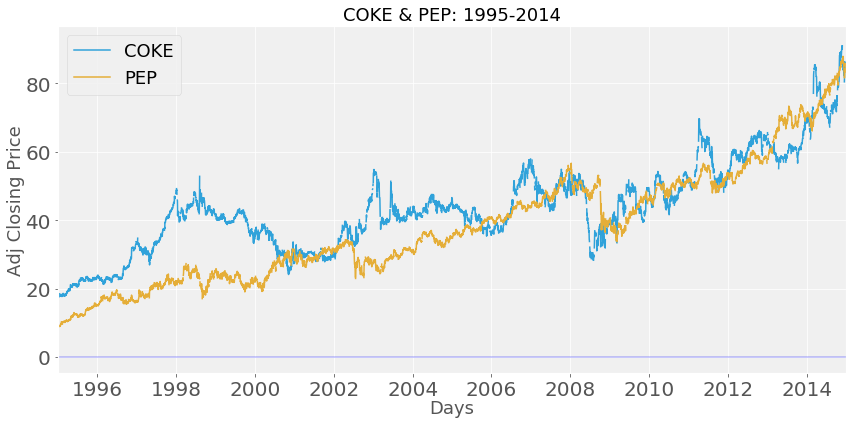

In [61]:
### Plot levels
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(dfyf_cp[['COKE']], label='COKE')
axes.plot(dfyf_cp[['PEP']], label='PEP')

axes.set_xlim(dfyf_cp.index.min(), dfyf_cp.index.max())
axes.set_xlabel('Days', fontsize=18)
axes.set_ylabel('Adj Closing Price', fontsize=18)
axes.set_title('COKE & PEP: ' + str(dfyf_cp.index.min().year) + '-' + str(dfyf_cp.index.max().year), fontsize=18)
axes.axhline(y=0, linewidth=0.4)
axes.legend(fontsize=18, loc='best')
fig.tight_layout()

We can see that both stocks move together with a common trend. Moreover, for some periods, one stock is higher than the other, vice versa. 

Let's proceed in a similar manner as we did in **Example 1** and analyze the cointegrating relationship between **COKE** and **PEP**. 

Let's define $X_{1,t}$ to be the **COKE** price time series and $X_{2,t}$ the **PEP** price time series.

Let's start by taking natural logs of each price series.

In [62]:
### Take logs
dfyf_cp['log_COKE'] = dfyf_cp['COKE'].apply(np.log)
dfyf_cp['log_PEP'] = dfyf_cp['PEP'].apply(np.log)

print(dfyf_cp.info(), '\n')
display(multi_table([dfyf_cp.head(), dfyf_cp.tail()]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7305 entries, 1995-01-01 to 2014-12-31
Freq: D
Data columns (total 4 columns):
COKE        5036 non-null float64
PEP         5036 non-null float64
log_COKE    5036 non-null float64
log_PEP     5036 non-null float64
dtypes: float64(4)
memory usage: 285.4 KB
None 



Symbols,COKE,PEP,log_COKE,log_PEP
Date,,,,
1995-01-01,nan,nan,nan,nan
1995-01-02,nan,nan,nan,nan
1995-01-03,16.939,9.460,2.830,2.247
1995-01-04,17.183,9.329,2.844,2.233
1995-01-05,17.427,9.132,2.858,2.212
Symbols,COKE,PEP,log_COKE,log_PEP
Date,,,,
2014-12-27,nan,nan,nan,nan
2014-12-28,nan,nan,nan,nan


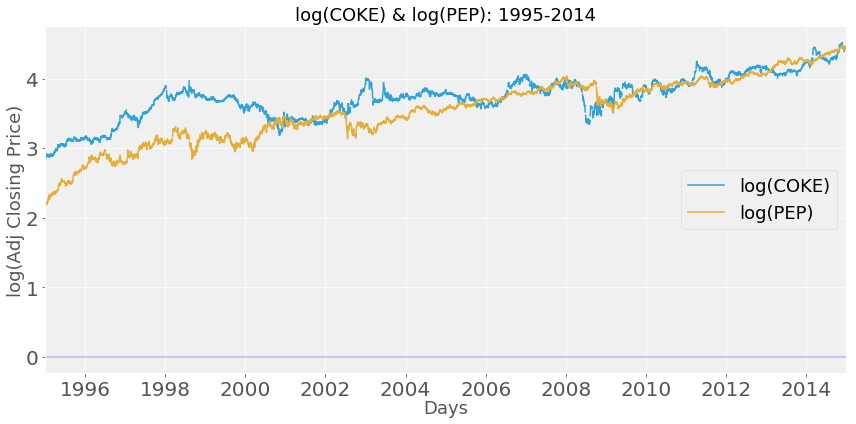

In [63]:
### Plot logs
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(dfyf_cp[['log_COKE']], label='log(COKE)')
axes.plot(dfyf_cp[['log_PEP']], label='log(PEP)')

axes.set_xlim(dfyf_cp.index.min(), dfyf_cp.index.max())
axes.set_xlabel('Days', fontsize=18)
axes.set_ylabel('log(Adj Closing Price)', fontsize=18)
axes.set_title('log(COKE) & log(PEP): ' + str(dfyf_cp.index.min().year) + '-' 
               + str(dfyf_cp.index.max().year), fontsize=18)
axes.axhline(y=0, linewidth=0.4)
axes.legend(fontsize=18, loc='best')
fig.tight_layout()

Let's take log differences of the prices as well:

In [64]:
### Take log differences
dfyf_cp['dlog_COKE'] = dfyf_cp['log_COKE'].diff()
dfyf_cp['dlog_PEP']  = dfyf_cp['log_PEP'].diff()

print(dfyf_cp.info(), '\n')
display(multi_table([dfyf_cp.head(), dfyf_cp.tail()]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7305 entries, 1995-01-01 to 2014-12-31
Freq: D
Data columns (total 6 columns):
COKE         5036 non-null float64
PEP          5036 non-null float64
log_COKE     5036 non-null float64
log_PEP      5036 non-null float64
dlog_COKE    3944 non-null float64
dlog_PEP     3944 non-null float64
dtypes: float64(6)
memory usage: 399.5 KB
None 



Symbols,COKE,PEP,log_COKE,log_PEP,dlog_COKE,dlog_PEP
Date,,,,,,
1995-01-01,nan,nan,nan,nan,nan,nan
1995-01-02,nan,nan,nan,nan,nan,nan
1995-01-03,16.939,9.460,2.830,2.247,nan,nan
1995-01-04,17.183,9.329,2.844,2.233,0.014,-0.014
1995-01-05,17.427,9.132,2.858,2.212,0.014,-0.021
Symbols,COKE,PEP,log_COKE,log_PEP,dlog_COKE,dlog_PEP
Date,,,,,,
2014-12-27,nan,nan,nan,nan,nan,nan
2014-12-28,nan,nan,nan,nan,nan,nan


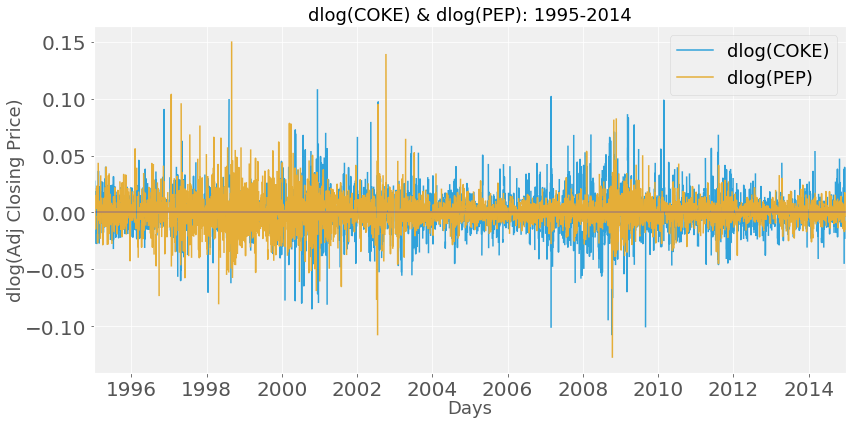

In [65]:
### Plot log differences
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(dfyf_cp[['dlog_COKE']], label='dlog(COKE)')
axes.plot(dfyf_cp[['dlog_PEP']], label='dlog(PEP)')

axes.set_xlim(dfyf_cp.index.min(), dfyf_cp.index.max())
axes.set_xlabel('Days', fontsize=18)
axes.set_ylabel('dlog(Adj Closing Price)', fontsize=18)
axes.set_title('dlog(COKE) & dlog(PEP): ' + str(dfyf_cp.index.min().year) + '-' 
               + str(dfyf_cp.index.max().year), fontsize=18)
axes.axhline(y=0, linewidth=0.4)
axes.legend(fontsize=18, loc='best')
fig.tight_layout()

### Unit-root tests (Augmented Dickey-Fuller):

Let's run ADF tests for stationarity on the log prices and log differences of prices: $log(X_{i,t})$, $\Delta log(X_{i,t})$ for $i=1,2$.

In [66]:
### Drop missings
dfyf_cp = dfyf_cp.dropna()

In [67]:
def ADF_test(df, col_idx): 
    adf_result = sm.tsa.stattools.adfuller(df[col_idx])
    print(col_idx, ': ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result[0], adf_result[1]),
          '\n\tcritical values', adf_result[4],'\n')

#### ADF test for $log(X_{1,t})\equiv log(COKE_{t})$

In [68]:
ADF_test(df=dfyf_cp, col_idx='log_COKE')

log_COKE : ADF statistic (p-value): -2.021 (0.278) 
	critical values {'1%': -3.4320129151078773, '5%': -2.8622747848972327, '10%': -2.5671611343964584} 



#### ADF test for $\Delta log(X_{1,t})\equiv \Delta log(COKE_{t})$

In [69]:
ADF_test(df=dfyf_cp, col_idx='dlog_COKE')

dlog_COKE : ADF statistic (p-value): -32.767 (0.000) 
	critical values {'1%': -3.432010803432236, '5%': -2.86227385208086, '10%': -2.567160637803087} 



#### ADF test for $log(X_{2,t})\equiv log(PEP_{t})$

In [70]:
ADF_test(df=dfyf_cp, col_idx='log_PEP')

log_PEP : ADF statistic (p-value): -2.195 (0.208) 
	critical values {'1%': -3.4320116474585953, '5%': -2.862274224923052, '10%': -2.567160836289042} 



#### ADF test for $\Delta log(X_{2,t})\equiv \Delta log(PEP_{t})$

In [71]:
ADF_test(df=dfyf_cp, col_idx='dlog_PEP')

dlog_PEP : ADF statistic (p-value): -16.827 (0.000) 
	critical values {'1%': -3.432015456217749, '5%': -2.862275907411977, '10%': -2.5671617319776505} 



The unit root tests suggest both the log of $COKE$ and $PEP$ daily prices are **nonstationary**.

Let's now estimate the cointegrating vector $\mathbf{\alpha}$ via **Dynamic OLS** and construct the cointegrating error/residual 

$$
\begin{align*}
    z_t = 
    \begin{pmatrix}
        \alpha_{COKE} & \alpha_{PEP}
    \end{pmatrix}\cdot
     \begin{pmatrix}
        \log(COKE_t) \\ \log(PEP_t)
    \end{pmatrix}\  
\end{align*}      
$$


/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:               log_COKE   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     59.83
Date:                Sat, 18 May 2019   Prob (F-statistic):          5.89e-200
Time:                        03:22:31   Log-Likelihood:                 1521.9
No. Observations:                3925   AIC:                            -3004.
Df Residuals:                    3905   BIC:                            -2878.
Df Model:                          19                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7439      0.064     27.075      0.0

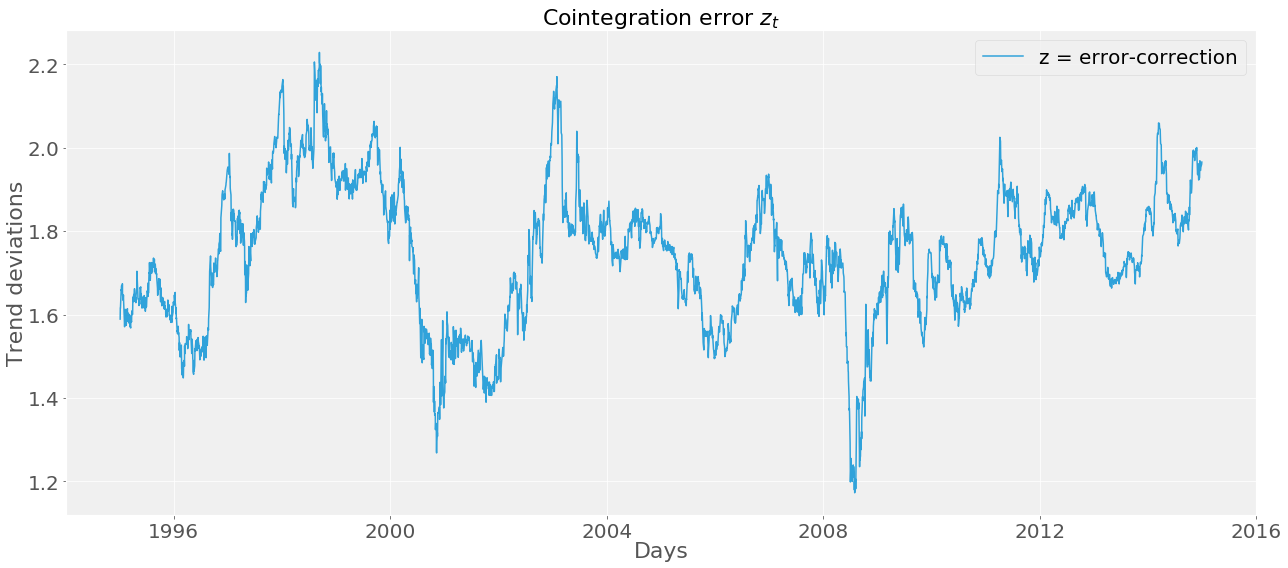

In [72]:
x1 = dfyf_cp[['log_COKE']]
x2 = dfyf_cp[['log_PEP']]

dols_fit = dols_cointegrating_vec(x1, x2, k_lags=10, incl_trend=False)
print(dols_fit.summary(),'\n')

gamma_dols = np.array([1, -dols_fit.params[1]])
z_dols = pd.DataFrame(get_cointegrating_vec(x1, x2, gamma_dols, remove_trend=False), index=dfyf_cp.index)
z_dols.index   = dfyf_cp.index
z_dols.columns = ['ec']

dfyf_cp['ec_dols'] = z_dols

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))        
axes.plot(z_dols['ec'], label='z = error-correction')
axes.set_title('Cointegration error $z_t$', fontsize=22)
axes.set_xlabel('Days', fontsize=22)
axes.set_ylabel('Trend deviations', fontsize=22)
axes.legend(fontsize=20)
fig.tight_layout()

We reject the null hypothesis $\mathbf{H}_0$ of a unit root in the cointegrating residual $z_t$ (at the 5% significance level).

The cointegrating vector estimate via **DOLS**, $\widehat{\alpha}_{DOLS}$, is $(1, -0.562)$

### Estimating the VECM($p$). 

Let's now estimate a VECM($p$) and choose the optimal lag length $p$ using *BIC*. For this, we will use the `statsmodel` VECM routine.

In [73]:
### "statsmodels" estimation of VECM(p)
X = dfyf_cp[['log_COKE', 'log_PEP']]
print(select_order(X, maxlags=10).summary())
pstar = select_order(X, maxlags=10).bic

vecm_model = VECM(X, k_ar_diff=pstar, deterministic='co').fit()
gamma_vecm_statsmodels = vecm_model.alpha
alpha_vecm_statsmodels = vecm_model.beta

print("Estimated gamma : ", gamma_vecm_statsmodels.flat[:])
print("Estimated alpha : ", alpha_vecm_statsmodels.flat[:], '\n')
print(vecm_model.summary(), '\n')

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.08      -16.07   1.039e-07      -16.08
1       -16.09     -16.07*   1.029e-07     -16.08*
2       -16.09      -16.07   1.028e-07      -16.08
3      -16.09*      -16.06  1.027e-07*      -16.08
4       -16.09      -16.06   1.028e-07      -16.08
5       -16.09      -16.05   1.029e-07      -16.08
6       -16.09      -16.04   1.029e-07      -16.07
7       -16.09      -16.03   1.030e-07      -16.07
8       -16.09      -16.03   1.030e-07      -16.07
9       -16.09      -16.02   1.031e-07      -16.06
10      -16.09      -16.01   1.031e-07      -16.06
--------------------------------------------------
Estimated gamma :  [-0.00603  0.00197]
Estimated alpha :  [ 1.      -0.61432] 

Det. terms outside the coint. relation & lagged endog. parameters for equation log_COKE
                  coef    std err          z      P>|z|      [0.025

We obtain the estimate $\widehat{\gamma}=(-0.006, 0.002)^{\prime}$ with $log(COKE_t)$ error-correcting.

### Trading Strategy: 

Based on our cointegrating estimates, we can construct an operational trading strategy that shorts the stock <u>above</u> the common trend and buys the stock <u>below</u> the common trend. When the two stocks converge (here, when $log(COKE)$ error-corrects towards the common trend) we reverse our positions. 